# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

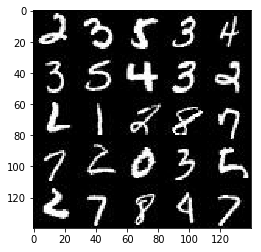

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

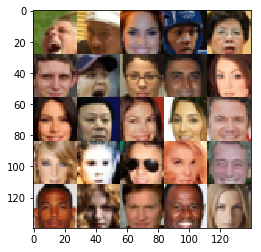

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    inputs_real = tf.placeholder(tf.float32, (None,image_width,image_height,image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    with tf.variable_scope('discriminator', reuse=reuse):
        # 28x28x1(MNIST) || 28x28x3(CelebA)
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        bn1 = tf.layers.batch_normalization(x1, training=True)
        relu1 = tf.maximum(alpha * x1, x1)
        
        # 14x14x64
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        # 7x7x128
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        # 4x4x256
        x4 = tf.layers.conv2d(relu3, 512, 5, strides=2, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        
        # 2x2x512
        #Flatten
        relu_shape = relu4.shape.as_list()
        
        flat = tf.reshape(relu4, (-1, relu_shape[1]*relu_shape[2]*relu_shape[3]))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = False if is_train==True else True  
        
    with tf.variable_scope('generator',reuse=not is_train):        
        # 7x7x512
        flat = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(flat, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        
        # 14x14x256
        x2 = tf.layers.conv2d_transpose(
            relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        # 14x14x128
        x3 = tf.layers.conv2d_transpose(
            relu2, 128, 5, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        # 28x28x64
        x4 = tf.layers.conv2d_transpose(
            relu3, 64, 3, strides=2, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=is_train)
        relu4 = tf.maximum(alpha * bn4, bn4)
        
        #28 x 28 x odim
        logits = tf.layers.conv2d_transpose(relu4, 
                                            out_channel_dim, 
                                            5, 
                                            strides=1, 
                                            padding='same')
        
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_update_ops = [op for op in update_ops if op.name.startswith('generator')]
    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, image_w, image_h, image_c = data_shape
    input_real, input_z, lr = model_inputs(image_w, image_h, image_c, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_c)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images*2
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})

                # Print the loss every 10 steps:
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    d_loss_train = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    g_loss_train = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(d_loss_train),
                          "Generator Loss: {:.4f}".format(g_loss_train))
                # Show images every 100 steps  
                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, image_c, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8562... Generator Loss: 0.9167
Epoch 1/2... Discriminator Loss: 1.7853... Generator Loss: 0.4114
Epoch 1/2... Discriminator Loss: 3.0073... Generator Loss: 0.0571
Epoch 1/2... Discriminator Loss: 1.7066... Generator Loss: 0.9465
Epoch 1/2... Discriminator Loss: 1.3347... Generator Loss: 0.7482
Epoch 1/2... Discriminator Loss: 2.5048... Generator Loss: 0.1226
Epoch 1/2... Discriminator Loss: 2.6232... Generator Loss: 0.6914
Epoch 1/2... Discriminator Loss: 2.0005... Generator Loss: 2.1801
Epoch 1/2... Discriminator Loss: 1.3971... Generator Loss: 0.7635
Epoch 1/2... Discriminator Loss: 2.2770... Generator Loss: 0.1495


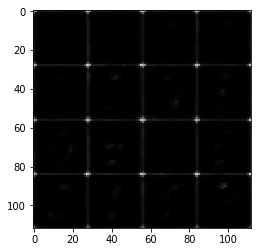

Epoch 1/2... Discriminator Loss: 1.3782... Generator Loss: 0.4371
Epoch 1/2... Discriminator Loss: 2.2948... Generator Loss: 0.1462
Epoch 1/2... Discriminator Loss: 1.7077... Generator Loss: 0.3512
Epoch 1/2... Discriminator Loss: 1.6366... Generator Loss: 0.2714
Epoch 1/2... Discriminator Loss: 1.6819... Generator Loss: 0.3348
Epoch 1/2... Discriminator Loss: 1.8015... Generator Loss: 0.2414
Epoch 1/2... Discriminator Loss: 1.2722... Generator Loss: 0.6075
Epoch 1/2... Discriminator Loss: 0.9962... Generator Loss: 0.9302
Epoch 1/2... Discriminator Loss: 1.8988... Generator Loss: 0.2174
Epoch 1/2... Discriminator Loss: 1.3804... Generator Loss: 1.2109


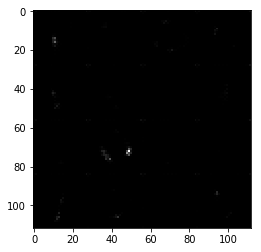

Epoch 1/2... Discriminator Loss: 0.9604... Generator Loss: 0.9731
Epoch 1/2... Discriminator Loss: 1.3946... Generator Loss: 0.6777
Epoch 1/2... Discriminator Loss: 1.1481... Generator Loss: 0.5352
Epoch 1/2... Discriminator Loss: 1.0022... Generator Loss: 1.1407
Epoch 1/2... Discriminator Loss: 2.9711... Generator Loss: 0.0922
Epoch 1/2... Discriminator Loss: 1.5817... Generator Loss: 0.4676
Epoch 1/2... Discriminator Loss: 1.3946... Generator Loss: 0.4558
Epoch 1/2... Discriminator Loss: 1.9274... Generator Loss: 0.2034
Epoch 1/2... Discriminator Loss: 1.7134... Generator Loss: 0.5811
Epoch 1/2... Discriminator Loss: 1.6053... Generator Loss: 0.4023


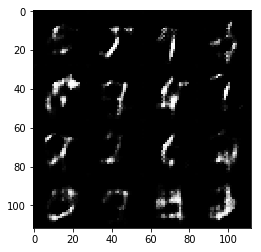

Epoch 1/2... Discriminator Loss: 1.1292... Generator Loss: 0.5994
Epoch 1/2... Discriminator Loss: 1.4640... Generator Loss: 0.6237
Epoch 1/2... Discriminator Loss: 1.4566... Generator Loss: 1.4731
Epoch 1/2... Discriminator Loss: 2.0299... Generator Loss: 0.1913
Epoch 1/2... Discriminator Loss: 1.9061... Generator Loss: 0.4043
Epoch 1/2... Discriminator Loss: 1.3968... Generator Loss: 0.4757
Epoch 1/2... Discriminator Loss: 2.3457... Generator Loss: 0.2401
Epoch 1/2... Discriminator Loss: 1.2955... Generator Loss: 0.4449
Epoch 1/2... Discriminator Loss: 1.2604... Generator Loss: 0.5990
Epoch 1/2... Discriminator Loss: 1.3342... Generator Loss: 0.7451


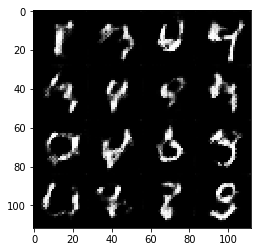

Epoch 1/2... Discriminator Loss: 1.2700... Generator Loss: 0.7236
Epoch 1/2... Discriminator Loss: 1.3425... Generator Loss: 0.4030
Epoch 1/2... Discriminator Loss: 1.2829... Generator Loss: 0.4746
Epoch 1/2... Discriminator Loss: 1.4943... Generator Loss: 0.5614
Epoch 1/2... Discriminator Loss: 0.9603... Generator Loss: 0.8664
Epoch 1/2... Discriminator Loss: 1.7792... Generator Loss: 0.2860
Epoch 1/2... Discriminator Loss: 1.5673... Generator Loss: 0.3260
Epoch 1/2... Discriminator Loss: 1.4670... Generator Loss: 0.4326
Epoch 1/2... Discriminator Loss: 2.0372... Generator Loss: 0.2187
Epoch 1/2... Discriminator Loss: 1.6411... Generator Loss: 0.3086


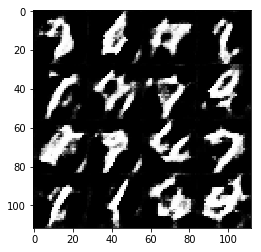

Epoch 1/2... Discriminator Loss: 1.4087... Generator Loss: 0.6161
Epoch 1/2... Discriminator Loss: 0.8191... Generator Loss: 1.0948
Epoch 1/2... Discriminator Loss: 1.1198... Generator Loss: 0.6227
Epoch 1/2... Discriminator Loss: 0.9918... Generator Loss: 0.9272
Epoch 1/2... Discriminator Loss: 1.0890... Generator Loss: 0.5371
Epoch 1/2... Discriminator Loss: 1.4755... Generator Loss: 0.3573
Epoch 1/2... Discriminator Loss: 0.8312... Generator Loss: 0.9608
Epoch 1/2... Discriminator Loss: 1.1320... Generator Loss: 0.8216
Epoch 1/2... Discriminator Loss: 1.4631... Generator Loss: 0.4266
Epoch 1/2... Discriminator Loss: 0.9982... Generator Loss: 0.5656


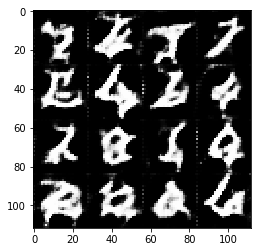

Epoch 1/2... Discriminator Loss: 0.8264... Generator Loss: 1.4473
Epoch 1/2... Discriminator Loss: 1.1962... Generator Loss: 0.4694
Epoch 1/2... Discriminator Loss: 1.0675... Generator Loss: 0.5132
Epoch 1/2... Discriminator Loss: 1.2045... Generator Loss: 0.6871
Epoch 1/2... Discriminator Loss: 1.5170... Generator Loss: 0.3766
Epoch 1/2... Discriminator Loss: 0.8193... Generator Loss: 0.7924
Epoch 1/2... Discriminator Loss: 0.4752... Generator Loss: 1.4251
Epoch 1/2... Discriminator Loss: 1.2561... Generator Loss: 0.4580
Epoch 1/2... Discriminator Loss: 0.6248... Generator Loss: 1.5297
Epoch 1/2... Discriminator Loss: 1.3844... Generator Loss: 0.8413


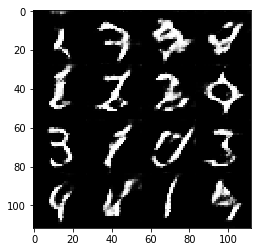

Epoch 1/2... Discriminator Loss: 1.6322... Generator Loss: 0.2861
Epoch 1/2... Discriminator Loss: 1.5846... Generator Loss: 0.2852
Epoch 1/2... Discriminator Loss: 0.8572... Generator Loss: 0.7583
Epoch 1/2... Discriminator Loss: 1.3913... Generator Loss: 0.4632
Epoch 1/2... Discriminator Loss: 4.4499... Generator Loss: 0.0155
Epoch 1/2... Discriminator Loss: 1.2886... Generator Loss: 0.6145
Epoch 1/2... Discriminator Loss: 1.1014... Generator Loss: 0.7124
Epoch 1/2... Discriminator Loss: 1.2959... Generator Loss: 0.5747
Epoch 1/2... Discriminator Loss: 1.4019... Generator Loss: 0.4896
Epoch 1/2... Discriminator Loss: 1.0037... Generator Loss: 0.5755


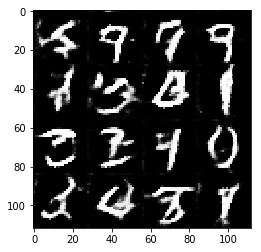

Epoch 1/2... Discriminator Loss: 0.4660... Generator Loss: 1.6181
Epoch 1/2... Discriminator Loss: 2.4455... Generator Loss: 0.1219
Epoch 1/2... Discriminator Loss: 1.5143... Generator Loss: 0.3654
Epoch 1/2... Discriminator Loss: 0.9318... Generator Loss: 0.9890
Epoch 1/2... Discriminator Loss: 1.1013... Generator Loss: 0.5092
Epoch 1/2... Discriminator Loss: 1.0834... Generator Loss: 0.6648
Epoch 1/2... Discriminator Loss: 1.3467... Generator Loss: 0.4044
Epoch 1/2... Discriminator Loss: 1.7568... Generator Loss: 0.3762
Epoch 1/2... Discriminator Loss: 1.0634... Generator Loss: 0.5023
Epoch 1/2... Discriminator Loss: 0.5962... Generator Loss: 1.6224


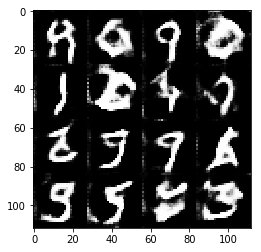

Epoch 1/2... Discriminator Loss: 2.4284... Generator Loss: 0.1148
Epoch 1/2... Discriminator Loss: 1.0503... Generator Loss: 0.5401
Epoch 1/2... Discriminator Loss: 0.6875... Generator Loss: 0.9195
Epoch 1/2... Discriminator Loss: 1.4532... Generator Loss: 0.5173
Epoch 1/2... Discriminator Loss: 0.3913... Generator Loss: 1.8775
Epoch 1/2... Discriminator Loss: 1.7978... Generator Loss: 0.2414
Epoch 1/2... Discriminator Loss: 2.6704... Generator Loss: 0.1187
Epoch 1/2... Discriminator Loss: 1.3677... Generator Loss: 0.4544
Epoch 1/2... Discriminator Loss: 1.9978... Generator Loss: 0.1941
Epoch 1/2... Discriminator Loss: 1.2543... Generator Loss: 1.0476


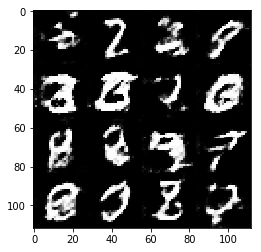

Epoch 1/2... Discriminator Loss: 1.6207... Generator Loss: 0.2613
Epoch 1/2... Discriminator Loss: 1.4801... Generator Loss: 0.3372
Epoch 1/2... Discriminator Loss: 0.8379... Generator Loss: 0.9469
Epoch 1/2... Discriminator Loss: 2.8706... Generator Loss: 0.0820
Epoch 1/2... Discriminator Loss: 2.4945... Generator Loss: 0.1064
Epoch 1/2... Discriminator Loss: 1.4127... Generator Loss: 0.3522
Epoch 1/2... Discriminator Loss: 0.6197... Generator Loss: 1.0565
Epoch 1/2... Discriminator Loss: 1.3695... Generator Loss: 0.4498
Epoch 1/2... Discriminator Loss: 1.1899... Generator Loss: 0.7085
Epoch 1/2... Discriminator Loss: 1.6301... Generator Loss: 0.3953


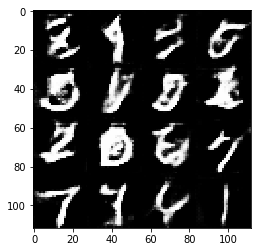

Epoch 1/2... Discriminator Loss: 0.7766... Generator Loss: 0.8778
Epoch 1/2... Discriminator Loss: 1.3319... Generator Loss: 0.3883
Epoch 1/2... Discriminator Loss: 1.1159... Generator Loss: 0.6010
Epoch 1/2... Discriminator Loss: 1.0880... Generator Loss: 1.3841
Epoch 1/2... Discriminator Loss: 0.6611... Generator Loss: 0.8647
Epoch 1/2... Discriminator Loss: 0.6869... Generator Loss: 0.8434
Epoch 1/2... Discriminator Loss: 1.1523... Generator Loss: 0.5532
Epoch 1/2... Discriminator Loss: 0.9708... Generator Loss: 0.6998
Epoch 1/2... Discriminator Loss: 2.3581... Generator Loss: 0.1212
Epoch 1/2... Discriminator Loss: 1.2877... Generator Loss: 0.4653


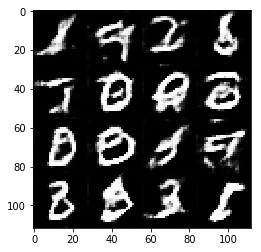

Epoch 1/2... Discriminator Loss: 0.5205... Generator Loss: 1.7591
Epoch 1/2... Discriminator Loss: 0.7193... Generator Loss: 1.0970
Epoch 1/2... Discriminator Loss: 1.4928... Generator Loss: 0.5555
Epoch 1/2... Discriminator Loss: 1.0596... Generator Loss: 0.6107
Epoch 1/2... Discriminator Loss: 1.8771... Generator Loss: 0.6383
Epoch 1/2... Discriminator Loss: 1.3746... Generator Loss: 0.3673
Epoch 1/2... Discriminator Loss: 0.8022... Generator Loss: 0.7911
Epoch 1/2... Discriminator Loss: 0.4668... Generator Loss: 1.4843
Epoch 1/2... Discriminator Loss: 0.8243... Generator Loss: 0.7130
Epoch 1/2... Discriminator Loss: 1.4719... Generator Loss: 0.4305


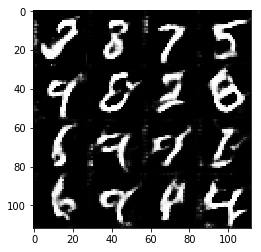

Epoch 1/2... Discriminator Loss: 1.5359... Generator Loss: 0.3053
Epoch 1/2... Discriminator Loss: 1.6874... Generator Loss: 0.3007
Epoch 1/2... Discriminator Loss: 1.4145... Generator Loss: 0.3974
Epoch 1/2... Discriminator Loss: 0.9376... Generator Loss: 0.7460
Epoch 1/2... Discriminator Loss: 0.8863... Generator Loss: 0.6717
Epoch 1/2... Discriminator Loss: 0.5067... Generator Loss: 1.4417
Epoch 1/2... Discriminator Loss: 0.9389... Generator Loss: 0.6077
Epoch 1/2... Discriminator Loss: 0.9189... Generator Loss: 0.6498
Epoch 1/2... Discriminator Loss: 1.3558... Generator Loss: 0.4780
Epoch 1/2... Discriminator Loss: 1.0761... Generator Loss: 0.5355


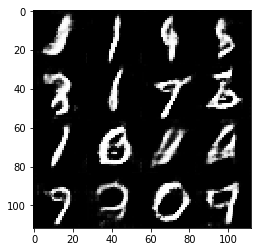

Epoch 1/2... Discriminator Loss: 1.3092... Generator Loss: 0.4755
Epoch 1/2... Discriminator Loss: 1.1144... Generator Loss: 0.4899
Epoch 1/2... Discriminator Loss: 1.2496... Generator Loss: 0.6079
Epoch 1/2... Discriminator Loss: 1.5570... Generator Loss: 0.3098
Epoch 1/2... Discriminator Loss: 0.9558... Generator Loss: 0.8822
Epoch 1/2... Discriminator Loss: 1.3630... Generator Loss: 0.3991
Epoch 1/2... Discriminator Loss: 1.2716... Generator Loss: 0.4512
Epoch 1/2... Discriminator Loss: 1.2932... Generator Loss: 0.5010
Epoch 1/2... Discriminator Loss: 0.9330... Generator Loss: 0.6278
Epoch 1/2... Discriminator Loss: 1.0610... Generator Loss: 0.5678


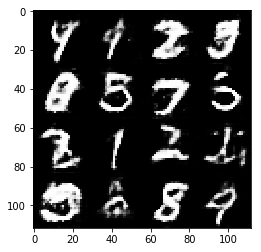

Epoch 1/2... Discriminator Loss: 2.0687... Generator Loss: 0.2822
Epoch 1/2... Discriminator Loss: 1.3370... Generator Loss: 0.4855
Epoch 1/2... Discriminator Loss: 0.8448... Generator Loss: 0.9177
Epoch 1/2... Discriminator Loss: 1.1519... Generator Loss: 0.8760
Epoch 1/2... Discriminator Loss: 1.9817... Generator Loss: 0.1664
Epoch 1/2... Discriminator Loss: 0.9456... Generator Loss: 0.7639
Epoch 1/2... Discriminator Loss: 2.5359... Generator Loss: 0.0954
Epoch 1/2... Discriminator Loss: 0.7306... Generator Loss: 1.0735
Epoch 1/2... Discriminator Loss: 0.8937... Generator Loss: 0.7524
Epoch 1/2... Discriminator Loss: 1.8764... Generator Loss: 0.2148


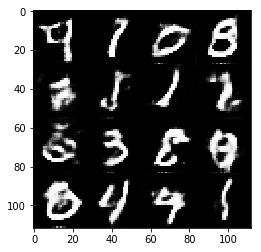

Epoch 1/2... Discriminator Loss: 0.8368... Generator Loss: 0.7540
Epoch 1/2... Discriminator Loss: 0.9233... Generator Loss: 0.7988
Epoch 1/2... Discriminator Loss: 0.7447... Generator Loss: 0.9971
Epoch 1/2... Discriminator Loss: 1.1023... Generator Loss: 0.5901
Epoch 1/2... Discriminator Loss: 1.4744... Generator Loss: 0.2917
Epoch 1/2... Discriminator Loss: 1.1222... Generator Loss: 0.9949
Epoch 1/2... Discriminator Loss: 0.7504... Generator Loss: 0.7803
Epoch 1/2... Discriminator Loss: 1.9957... Generator Loss: 0.3558
Epoch 1/2... Discriminator Loss: 1.9124... Generator Loss: 0.2124
Epoch 1/2... Discriminator Loss: 1.3852... Generator Loss: 0.3675


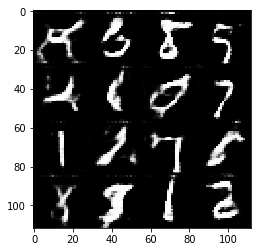

Epoch 1/2... Discriminator Loss: 1.0928... Generator Loss: 0.6257
Epoch 1/2... Discriminator Loss: 0.4010... Generator Loss: 1.5986
Epoch 1/2... Discriminator Loss: 0.9503... Generator Loss: 1.0884
Epoch 1/2... Discriminator Loss: 0.4432... Generator Loss: 2.3714
Epoch 1/2... Discriminator Loss: 0.9393... Generator Loss: 0.6045
Epoch 1/2... Discriminator Loss: 0.7274... Generator Loss: 1.2030
Epoch 1/2... Discriminator Loss: 0.9140... Generator Loss: 0.6016
Epoch 1/2... Discriminator Loss: 1.9796... Generator Loss: 0.2063
Epoch 1/2... Discriminator Loss: 0.3705... Generator Loss: 1.5360
Epoch 1/2... Discriminator Loss: 0.4830... Generator Loss: 1.2732


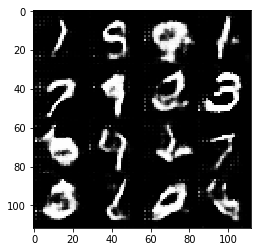

Epoch 1/2... Discriminator Loss: 1.5325... Generator Loss: 0.3026
Epoch 1/2... Discriminator Loss: 1.8462... Generator Loss: 0.2383
Epoch 1/2... Discriminator Loss: 2.5477... Generator Loss: 0.1450
Epoch 1/2... Discriminator Loss: 0.7872... Generator Loss: 0.9575
Epoch 1/2... Discriminator Loss: 1.5124... Generator Loss: 0.4575
Epoch 1/2... Discriminator Loss: 1.6211... Generator Loss: 0.3314
Epoch 1/2... Discriminator Loss: 1.2035... Generator Loss: 0.4536
Epoch 1/2... Discriminator Loss: 1.1930... Generator Loss: 0.8650
Epoch 1/2... Discriminator Loss: 1.6677... Generator Loss: 0.3633
Epoch 1/2... Discriminator Loss: 2.1860... Generator Loss: 0.1967


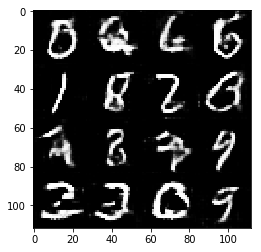

Epoch 1/2... Discriminator Loss: 0.6163... Generator Loss: 1.3711
Epoch 1/2... Discriminator Loss: 0.9362... Generator Loss: 0.7624
Epoch 1/2... Discriminator Loss: 1.2061... Generator Loss: 0.6041
Epoch 1/2... Discriminator Loss: 0.9901... Generator Loss: 0.6808
Epoch 1/2... Discriminator Loss: 1.0425... Generator Loss: 0.6038
Epoch 1/2... Discriminator Loss: 0.3907... Generator Loss: 1.3523
Epoch 1/2... Discriminator Loss: 0.6122... Generator Loss: 1.1667
Epoch 1/2... Discriminator Loss: 0.4281... Generator Loss: 1.5391
Epoch 1/2... Discriminator Loss: 1.0182... Generator Loss: 0.7173
Epoch 1/2... Discriminator Loss: 2.4207... Generator Loss: 0.1404


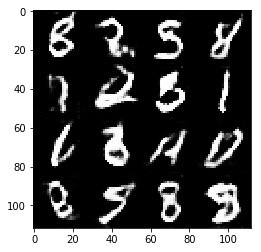

Epoch 1/2... Discriminator Loss: 1.8905... Generator Loss: 0.2242
Epoch 1/2... Discriminator Loss: 1.0329... Generator Loss: 0.8291
Epoch 1/2... Discriminator Loss: 1.4767... Generator Loss: 0.4156
Epoch 1/2... Discriminator Loss: 1.1688... Generator Loss: 0.4789
Epoch 1/2... Discriminator Loss: 0.8552... Generator Loss: 1.0166
Epoch 1/2... Discriminator Loss: 0.3702... Generator Loss: 2.6058
Epoch 1/2... Discriminator Loss: 0.9719... Generator Loss: 0.9395
Epoch 1/2... Discriminator Loss: 0.8366... Generator Loss: 0.7495
Epoch 1/2... Discriminator Loss: 1.0259... Generator Loss: 0.5530
Epoch 1/2... Discriminator Loss: 1.9206... Generator Loss: 0.1982


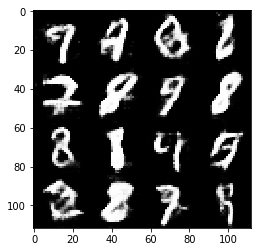

Epoch 1/2... Discriminator Loss: 1.3162... Generator Loss: 0.3958
Epoch 1/2... Discriminator Loss: 0.9221... Generator Loss: 0.7129
Epoch 1/2... Discriminator Loss: 0.9814... Generator Loss: 0.5908
Epoch 1/2... Discriminator Loss: 0.9733... Generator Loss: 1.3722
Epoch 1/2... Discriminator Loss: 1.2429... Generator Loss: 0.4801
Epoch 1/2... Discriminator Loss: 2.3283... Generator Loss: 0.1230
Epoch 1/2... Discriminator Loss: 0.7598... Generator Loss: 1.3315
Epoch 1/2... Discriminator Loss: 1.7784... Generator Loss: 0.3231
Epoch 1/2... Discriminator Loss: 0.6008... Generator Loss: 1.0521
Epoch 1/2... Discriminator Loss: 0.9734... Generator Loss: 0.7552


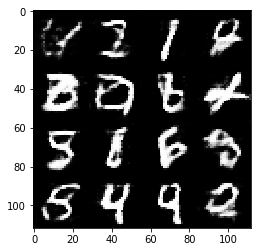

Epoch 1/2... Discriminator Loss: 0.9940... Generator Loss: 0.8177
Epoch 1/2... Discriminator Loss: 0.8294... Generator Loss: 0.7996
Epoch 1/2... Discriminator Loss: 1.7111... Generator Loss: 0.2436
Epoch 1/2... Discriminator Loss: 1.5374... Generator Loss: 0.3475
Epoch 1/2... Discriminator Loss: 1.8415... Generator Loss: 0.2381
Epoch 1/2... Discriminator Loss: 1.0569... Generator Loss: 0.5436
Epoch 1/2... Discriminator Loss: 0.7783... Generator Loss: 0.8909
Epoch 1/2... Discriminator Loss: 1.0917... Generator Loss: 0.5295
Epoch 1/2... Discriminator Loss: 1.4703... Generator Loss: 0.3154
Epoch 1/2... Discriminator Loss: 1.2889... Generator Loss: 0.4177


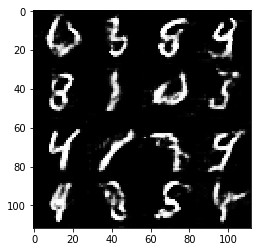

Epoch 1/2... Discriminator Loss: 1.4409... Generator Loss: 0.3588
Epoch 1/2... Discriminator Loss: 0.8037... Generator Loss: 1.0093
Epoch 1/2... Discriminator Loss: 2.5688... Generator Loss: 0.1181
Epoch 1/2... Discriminator Loss: 1.0156... Generator Loss: 0.6296
Epoch 1/2... Discriminator Loss: 1.0859... Generator Loss: 0.5307
Epoch 1/2... Discriminator Loss: 0.7308... Generator Loss: 0.8975
Epoch 1/2... Discriminator Loss: 0.5064... Generator Loss: 1.5281
Epoch 1/2... Discriminator Loss: 1.0505... Generator Loss: 0.6037
Epoch 1/2... Discriminator Loss: 0.8597... Generator Loss: 0.6835
Epoch 1/2... Discriminator Loss: 2.5189... Generator Loss: 0.1388


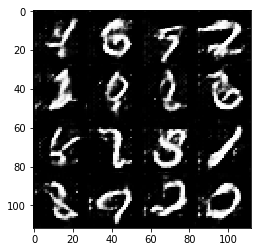

Epoch 1/2... Discriminator Loss: 2.0750... Generator Loss: 0.2101
Epoch 1/2... Discriminator Loss: 2.8691... Generator Loss: 0.0880
Epoch 1/2... Discriminator Loss: 1.2241... Generator Loss: 0.4378
Epoch 1/2... Discriminator Loss: 1.0231... Generator Loss: 0.9350
Epoch 1/2... Discriminator Loss: 1.6590... Generator Loss: 0.3462
Epoch 1/2... Discriminator Loss: 1.0379... Generator Loss: 0.5082
Epoch 1/2... Discriminator Loss: 1.8467... Generator Loss: 0.2249
Epoch 1/2... Discriminator Loss: 1.2160... Generator Loss: 0.5186
Epoch 1/2... Discriminator Loss: 2.9648... Generator Loss: 0.0756
Epoch 1/2... Discriminator Loss: 1.1971... Generator Loss: 0.5890


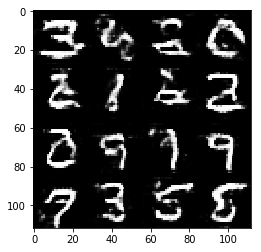

Epoch 1/2... Discriminator Loss: 1.2531... Generator Loss: 0.4326
Epoch 1/2... Discriminator Loss: 1.4570... Generator Loss: 0.3284
Epoch 1/2... Discriminator Loss: 1.7032... Generator Loss: 0.2422
Epoch 1/2... Discriminator Loss: 1.4473... Generator Loss: 2.0590
Epoch 1/2... Discriminator Loss: 0.3430... Generator Loss: 2.2243
Epoch 1/2... Discriminator Loss: 0.3580... Generator Loss: 1.7132
Epoch 1/2... Discriminator Loss: 0.5514... Generator Loss: 1.3231
Epoch 1/2... Discriminator Loss: 1.3634... Generator Loss: 1.0907
Epoch 1/2... Discriminator Loss: 0.5808... Generator Loss: 1.5220
Epoch 1/2... Discriminator Loss: 1.0866... Generator Loss: 0.8118


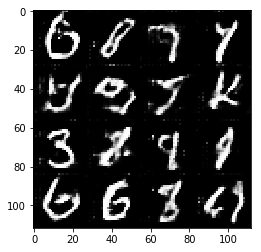

Epoch 1/2... Discriminator Loss: 2.4266... Generator Loss: 0.1412
Epoch 1/2... Discriminator Loss: 0.9864... Generator Loss: 0.6686
Epoch 1/2... Discriminator Loss: 0.6071... Generator Loss: 1.2638
Epoch 1/2... Discriminator Loss: 2.0316... Generator Loss: 0.1739
Epoch 1/2... Discriminator Loss: 2.1241... Generator Loss: 0.2225
Epoch 1/2... Discriminator Loss: 1.2239... Generator Loss: 0.4744
Epoch 1/2... Discriminator Loss: 0.6884... Generator Loss: 0.8254
Epoch 1/2... Discriminator Loss: 1.8750... Generator Loss: 0.3354
Epoch 1/2... Discriminator Loss: 1.2266... Generator Loss: 0.5343
Epoch 1/2... Discriminator Loss: 1.2967... Generator Loss: 0.4060


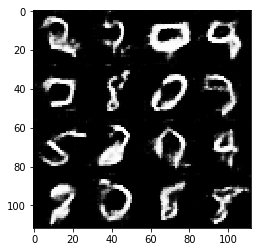

Epoch 1/2... Discriminator Loss: 1.6801... Generator Loss: 0.4416
Epoch 1/2... Discriminator Loss: 1.4745... Generator Loss: 0.4079
Epoch 1/2... Discriminator Loss: 1.9148... Generator Loss: 0.1899
Epoch 1/2... Discriminator Loss: 1.0677... Generator Loss: 0.7030
Epoch 1/2... Discriminator Loss: 0.3943... Generator Loss: 1.5026
Epoch 1/2... Discriminator Loss: 0.4817... Generator Loss: 1.4744
Epoch 1/2... Discriminator Loss: 1.3278... Generator Loss: 0.5743
Epoch 1/2... Discriminator Loss: 1.2248... Generator Loss: 0.4843
Epoch 1/2... Discriminator Loss: 1.1309... Generator Loss: 0.6607
Epoch 1/2... Discriminator Loss: 1.3545... Generator Loss: 0.4613


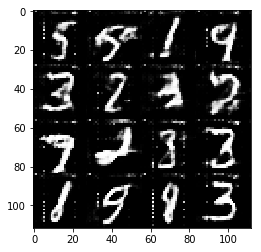

Epoch 1/2... Discriminator Loss: 1.1179... Generator Loss: 0.5296
Epoch 1/2... Discriminator Loss: 1.3559... Generator Loss: 0.4540
Epoch 1/2... Discriminator Loss: 1.0054... Generator Loss: 0.6039
Epoch 1/2... Discriminator Loss: 0.3738... Generator Loss: 1.5241
Epoch 1/2... Discriminator Loss: 0.6695... Generator Loss: 0.8455
Epoch 1/2... Discriminator Loss: 0.7182... Generator Loss: 0.8468
Epoch 1/2... Discriminator Loss: 0.6447... Generator Loss: 1.0718
Epoch 1/2... Discriminator Loss: 2.0859... Generator Loss: 0.1891
Epoch 1/2... Discriminator Loss: 1.1125... Generator Loss: 0.5963
Epoch 1/2... Discriminator Loss: 0.8735... Generator Loss: 2.7699


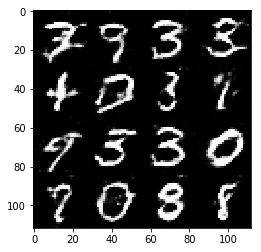

Epoch 1/2... Discriminator Loss: 2.7636... Generator Loss: 0.0764
Epoch 1/2... Discriminator Loss: 2.4844... Generator Loss: 1.9336
Epoch 1/2... Discriminator Loss: 1.6150... Generator Loss: 0.2824
Epoch 1/2... Discriminator Loss: 2.0862... Generator Loss: 0.1708
Epoch 1/2... Discriminator Loss: 0.8999... Generator Loss: 0.7271
Epoch 1/2... Discriminator Loss: 1.6696... Generator Loss: 0.3216
Epoch 1/2... Discriminator Loss: 1.2206... Generator Loss: 0.5214
Epoch 1/2... Discriminator Loss: 3.5434... Generator Loss: 0.0521
Epoch 1/2... Discriminator Loss: 1.4181... Generator Loss: 0.3159
Epoch 1/2... Discriminator Loss: 1.1456... Generator Loss: 0.5062


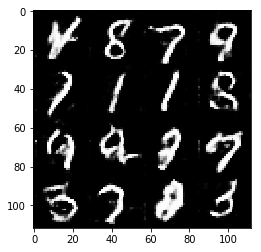

Epoch 1/2... Discriminator Loss: 0.5842... Generator Loss: 1.2391
Epoch 1/2... Discriminator Loss: 1.2525... Generator Loss: 0.4268
Epoch 1/2... Discriminator Loss: 2.0897... Generator Loss: 0.1701
Epoch 1/2... Discriminator Loss: 0.7058... Generator Loss: 1.0927
Epoch 1/2... Discriminator Loss: 0.1194... Generator Loss: 3.1439
Epoch 1/2... Discriminator Loss: 0.5376... Generator Loss: 1.2825
Epoch 1/2... Discriminator Loss: 0.4503... Generator Loss: 2.7415
Epoch 1/2... Discriminator Loss: 3.8679... Generator Loss: 0.0284
Epoch 1/2... Discriminator Loss: 1.6444... Generator Loss: 0.3510
Epoch 1/2... Discriminator Loss: 1.8814... Generator Loss: 0.1976


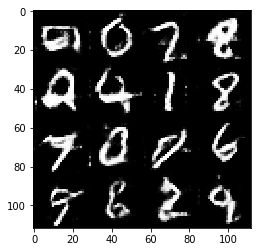

Epoch 1/2... Discriminator Loss: 0.7420... Generator Loss: 0.7673
Epoch 1/2... Discriminator Loss: 1.4363... Generator Loss: 0.6259
Epoch 1/2... Discriminator Loss: 0.8452... Generator Loss: 0.8807
Epoch 1/2... Discriminator Loss: 1.4934... Generator Loss: 0.2974
Epoch 1/2... Discriminator Loss: 0.5745... Generator Loss: 1.1168
Epoch 1/2... Discriminator Loss: 1.6753... Generator Loss: 0.4326
Epoch 1/2... Discriminator Loss: 0.3009... Generator Loss: 1.7350
Epoch 1/2... Discriminator Loss: 1.2777... Generator Loss: 0.5090
Epoch 1/2... Discriminator Loss: 0.4492... Generator Loss: 1.3296
Epoch 1/2... Discriminator Loss: 1.7349... Generator Loss: 0.2705


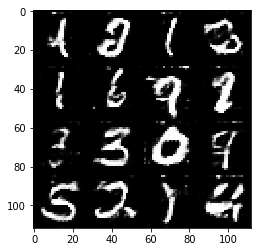

Epoch 1/2... Discriminator Loss: 0.5704... Generator Loss: 1.0584
Epoch 1/2... Discriminator Loss: 1.3478... Generator Loss: 0.3894
Epoch 1/2... Discriminator Loss: 2.6107... Generator Loss: 0.1091
Epoch 1/2... Discriminator Loss: 0.9817... Generator Loss: 0.5592
Epoch 1/2... Discriminator Loss: 1.2507... Generator Loss: 0.5015
Epoch 1/2... Discriminator Loss: 2.2978... Generator Loss: 0.1652
Epoch 1/2... Discriminator Loss: 1.0552... Generator Loss: 0.6119
Epoch 1/2... Discriminator Loss: 1.1425... Generator Loss: 0.4864
Epoch 1/2... Discriminator Loss: 2.2038... Generator Loss: 0.1359
Epoch 1/2... Discriminator Loss: 0.9422... Generator Loss: 0.7367


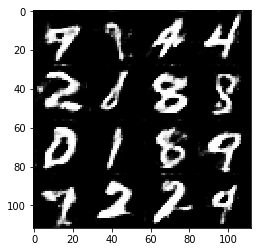

Epoch 1/2... Discriminator Loss: 1.4970... Generator Loss: 0.3815
Epoch 1/2... Discriminator Loss: 1.5767... Generator Loss: 0.4471
Epoch 1/2... Discriminator Loss: 1.1098... Generator Loss: 0.5806
Epoch 1/2... Discriminator Loss: 1.2589... Generator Loss: 0.6976
Epoch 1/2... Discriminator Loss: 0.4293... Generator Loss: 1.5535
Epoch 1/2... Discriminator Loss: 1.3362... Generator Loss: 0.3986
Epoch 1/2... Discriminator Loss: 0.7790... Generator Loss: 0.9011
Epoch 1/2... Discriminator Loss: 1.1478... Generator Loss: 0.4877
Epoch 1/2... Discriminator Loss: 0.4044... Generator Loss: 2.1014
Epoch 1/2... Discriminator Loss: 0.2876... Generator Loss: 1.6867


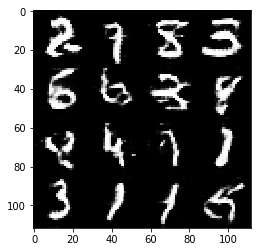

Epoch 1/2... Discriminator Loss: 1.2110... Generator Loss: 0.4226
Epoch 1/2... Discriminator Loss: 0.9258... Generator Loss: 0.6643
Epoch 1/2... Discriminator Loss: 1.8267... Generator Loss: 0.2526
Epoch 1/2... Discriminator Loss: 0.3388... Generator Loss: 1.6983
Epoch 1/2... Discriminator Loss: 0.8864... Generator Loss: 0.8399
Epoch 1/2... Discriminator Loss: 1.0215... Generator Loss: 0.5012
Epoch 1/2... Discriminator Loss: 2.6363... Generator Loss: 0.0937
Epoch 1/2... Discriminator Loss: 1.8785... Generator Loss: 0.1908
Epoch 1/2... Discriminator Loss: 1.4297... Generator Loss: 0.3894
Epoch 1/2... Discriminator Loss: 0.9221... Generator Loss: 0.7610


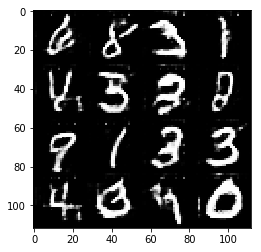

Epoch 1/2... Discriminator Loss: 0.9866... Generator Loss: 0.5773
Epoch 1/2... Discriminator Loss: 1.0679... Generator Loss: 0.5479
Epoch 1/2... Discriminator Loss: 1.7847... Generator Loss: 0.2378
Epoch 1/2... Discriminator Loss: 1.4196... Generator Loss: 0.3504
Epoch 1/2... Discriminator Loss: 1.7330... Generator Loss: 0.2616
Epoch 1/2... Discriminator Loss: 1.2763... Generator Loss: 0.4383
Epoch 1/2... Discriminator Loss: 2.0270... Generator Loss: 0.1812
Epoch 1/2... Discriminator Loss: 2.1669... Generator Loss: 0.2285
Epoch 1/2... Discriminator Loss: 1.0682... Generator Loss: 0.5443
Epoch 1/2... Discriminator Loss: 0.8041... Generator Loss: 1.0158


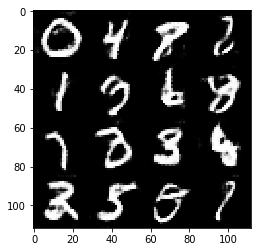

Epoch 1/2... Discriminator Loss: 0.9125... Generator Loss: 0.5707
Epoch 1/2... Discriminator Loss: 1.6823... Generator Loss: 0.2692
Epoch 1/2... Discriminator Loss: 1.3207... Generator Loss: 0.5693
Epoch 1/2... Discriminator Loss: 1.6714... Generator Loss: 0.3860
Epoch 1/2... Discriminator Loss: 0.8897... Generator Loss: 0.8544
Epoch 1/2... Discriminator Loss: 2.4213... Generator Loss: 0.1120
Epoch 1/2... Discriminator Loss: 1.2535... Generator Loss: 0.5300
Epoch 1/2... Discriminator Loss: 1.7882... Generator Loss: 0.3246
Epoch 1/2... Discriminator Loss: 0.8319... Generator Loss: 0.7769
Epoch 1/2... Discriminator Loss: 1.0536... Generator Loss: 0.6944


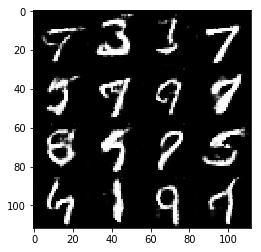

Epoch 1/2... Discriminator Loss: 1.8920... Generator Loss: 0.2535
Epoch 1/2... Discriminator Loss: 1.4229... Generator Loss: 0.3538
Epoch 1/2... Discriminator Loss: 0.4960... Generator Loss: 1.3325
Epoch 1/2... Discriminator Loss: 2.7913... Generator Loss: 0.0690
Epoch 1/2... Discriminator Loss: 1.7948... Generator Loss: 0.2860
Epoch 1/2... Discriminator Loss: 1.8603... Generator Loss: 0.2821
Epoch 1/2... Discriminator Loss: 2.5729... Generator Loss: 0.1127
Epoch 1/2... Discriminator Loss: 1.9254... Generator Loss: 0.2622
Epoch 1/2... Discriminator Loss: 1.7667... Generator Loss: 0.2467
Epoch 1/2... Discriminator Loss: 1.8835... Generator Loss: 0.2229


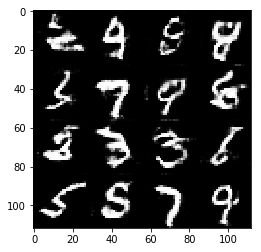

Epoch 1/2... Discriminator Loss: 1.3447... Generator Loss: 0.6167
Epoch 1/2... Discriminator Loss: 1.2175... Generator Loss: 0.4971
Epoch 1/2... Discriminator Loss: 0.4514... Generator Loss: 1.7488
Epoch 1/2... Discriminator Loss: 1.8860... Generator Loss: 0.2039
Epoch 1/2... Discriminator Loss: 0.9012... Generator Loss: 0.7419
Epoch 1/2... Discriminator Loss: 1.3573... Generator Loss: 0.4984
Epoch 1/2... Discriminator Loss: 0.4996... Generator Loss: 3.2687
Epoch 1/2... Discriminator Loss: 1.3519... Generator Loss: 0.4554
Epoch 1/2... Discriminator Loss: 1.5221... Generator Loss: 0.3314
Epoch 1/2... Discriminator Loss: 1.0158... Generator Loss: 0.4908


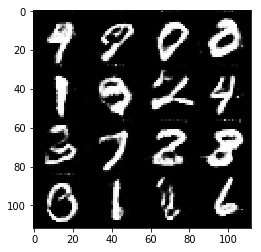

Epoch 1/2... Discriminator Loss: 1.3245... Generator Loss: 0.3728
Epoch 1/2... Discriminator Loss: 0.8345... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 0.4186... Generator Loss: 1.6714
Epoch 1/2... Discriminator Loss: 0.9134... Generator Loss: 1.8554
Epoch 1/2... Discriminator Loss: 1.2306... Generator Loss: 0.5877
Epoch 1/2... Discriminator Loss: 1.5700... Generator Loss: 0.3208
Epoch 1/2... Discriminator Loss: 1.8716... Generator Loss: 0.2056
Epoch 1/2... Discriminator Loss: 0.4526... Generator Loss: 1.5305
Epoch 1/2... Discriminator Loss: 1.0899... Generator Loss: 1.5656
Epoch 1/2... Discriminator Loss: 1.8836... Generator Loss: 0.2694


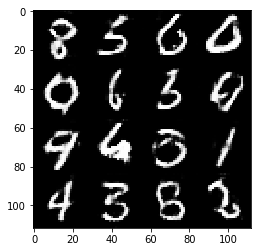

Epoch 1/2... Discriminator Loss: 1.6811... Generator Loss: 0.2467
Epoch 1/2... Discriminator Loss: 1.5142... Generator Loss: 0.3593
Epoch 1/2... Discriminator Loss: 0.8934... Generator Loss: 0.7383
Epoch 1/2... Discriminator Loss: 0.5900... Generator Loss: 1.2221
Epoch 1/2... Discriminator Loss: 2.0949... Generator Loss: 0.1880
Epoch 1/2... Discriminator Loss: 1.9290... Generator Loss: 0.2210
Epoch 1/2... Discriminator Loss: 1.4914... Generator Loss: 0.4047
Epoch 1/2... Discriminator Loss: 0.5742... Generator Loss: 1.0146
Epoch 1/2... Discriminator Loss: 0.3475... Generator Loss: 1.7216
Epoch 1/2... Discriminator Loss: 1.4469... Generator Loss: 0.3437


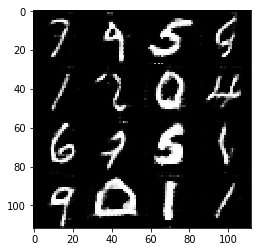

Epoch 1/2... Discriminator Loss: 1.4576... Generator Loss: 0.4007
Epoch 1/2... Discriminator Loss: 0.8129... Generator Loss: 0.9408
Epoch 1/2... Discriminator Loss: 1.3167... Generator Loss: 0.4225
Epoch 1/2... Discriminator Loss: 1.7207... Generator Loss: 0.2712
Epoch 1/2... Discriminator Loss: 1.5100... Generator Loss: 0.3350
Epoch 1/2... Discriminator Loss: 1.8705... Generator Loss: 0.2471
Epoch 1/2... Discriminator Loss: 1.5513... Generator Loss: 0.4708
Epoch 1/2... Discriminator Loss: 1.0560... Generator Loss: 0.5094
Epoch 1/2... Discriminator Loss: 1.7819... Generator Loss: 0.2347
Epoch 1/2... Discriminator Loss: 2.5236... Generator Loss: 0.1065


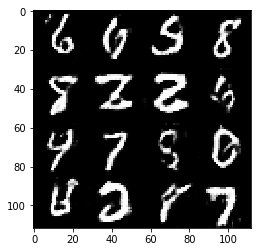

Epoch 1/2... Discriminator Loss: 1.3691... Generator Loss: 0.4117
Epoch 1/2... Discriminator Loss: 1.7295... Generator Loss: 0.3272
Epoch 1/2... Discriminator Loss: 0.3612... Generator Loss: 1.4534
Epoch 1/2... Discriminator Loss: 1.8694... Generator Loss: 0.2316
Epoch 1/2... Discriminator Loss: 0.2988... Generator Loss: 1.5970
Epoch 1/2... Discriminator Loss: 0.5058... Generator Loss: 1.0786
Epoch 1/2... Discriminator Loss: 2.4035... Generator Loss: 0.1023
Epoch 1/2... Discriminator Loss: 0.7296... Generator Loss: 1.1505
Epoch 1/2... Discriminator Loss: 2.3429... Generator Loss: 0.2521
Epoch 1/2... Discriminator Loss: 0.7576... Generator Loss: 1.2179


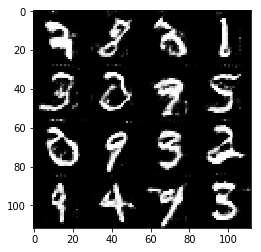

Epoch 1/2... Discriminator Loss: 1.8240... Generator Loss: 0.2952
Epoch 1/2... Discriminator Loss: 1.6145... Generator Loss: 0.2988
Epoch 1/2... Discriminator Loss: 1.4006... Generator Loss: 0.4056
Epoch 1/2... Discriminator Loss: 1.7679... Generator Loss: 0.3504
Epoch 1/2... Discriminator Loss: 0.4699... Generator Loss: 1.1780
Epoch 1/2... Discriminator Loss: 1.2944... Generator Loss: 0.5115
Epoch 1/2... Discriminator Loss: 1.6272... Generator Loss: 0.2898
Epoch 1/2... Discriminator Loss: 1.9152... Generator Loss: 0.1990
Epoch 1/2... Discriminator Loss: 2.4303... Generator Loss: 0.1299
Epoch 1/2... Discriminator Loss: 0.9070... Generator Loss: 0.6093


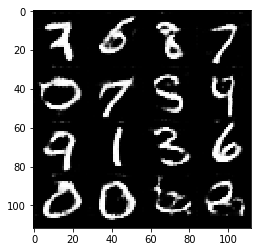

Epoch 1/2... Discriminator Loss: 0.4106... Generator Loss: 1.7174
Epoch 1/2... Discriminator Loss: 0.9603... Generator Loss: 0.8352
Epoch 1/2... Discriminator Loss: 0.8598... Generator Loss: 0.7032
Epoch 1/2... Discriminator Loss: 1.6255... Generator Loss: 0.2924
Epoch 1/2... Discriminator Loss: 0.8914... Generator Loss: 1.0444
Epoch 1/2... Discriminator Loss: 1.4778... Generator Loss: 0.3456
Epoch 1/2... Discriminator Loss: 1.4228... Generator Loss: 0.4809
Epoch 1/2... Discriminator Loss: 0.6502... Generator Loss: 2.1162
Epoch 1/2... Discriminator Loss: 2.7887... Generator Loss: 0.1030
Epoch 1/2... Discriminator Loss: 1.7369... Generator Loss: 0.2698


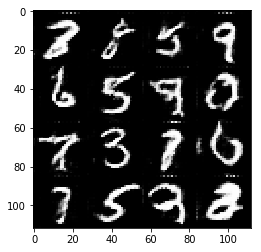

Epoch 1/2... Discriminator Loss: 1.8776... Generator Loss: 0.2382
Epoch 1/2... Discriminator Loss: 1.2225... Generator Loss: 0.4244
Epoch 1/2... Discriminator Loss: 0.7333... Generator Loss: 0.8951
Epoch 1/2... Discriminator Loss: 0.6806... Generator Loss: 0.9757
Epoch 1/2... Discriminator Loss: 1.1086... Generator Loss: 0.5426
Epoch 1/2... Discriminator Loss: 0.8950... Generator Loss: 0.6240
Epoch 1/2... Discriminator Loss: 1.7908... Generator Loss: 0.2212
Epoch 1/2... Discriminator Loss: 1.3340... Generator Loss: 0.4141
Epoch 1/2... Discriminator Loss: 0.9884... Generator Loss: 0.6440
Epoch 1/2... Discriminator Loss: 0.6698... Generator Loss: 1.0106


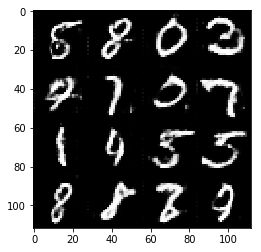

Epoch 1/2... Discriminator Loss: 0.8914... Generator Loss: 0.9727
Epoch 1/2... Discriminator Loss: 0.8047... Generator Loss: 1.1513
Epoch 1/2... Discriminator Loss: 2.2050... Generator Loss: 0.1493
Epoch 1/2... Discriminator Loss: 1.1839... Generator Loss: 0.4211
Epoch 1/2... Discriminator Loss: 2.2313... Generator Loss: 0.1728
Epoch 1/2... Discriminator Loss: 1.6421... Generator Loss: 0.2756
Epoch 1/2... Discriminator Loss: 1.2702... Generator Loss: 0.5278
Epoch 1/2... Discriminator Loss: 0.5087... Generator Loss: 1.4921
Epoch 1/2... Discriminator Loss: 0.7307... Generator Loss: 0.9767
Epoch 1/2... Discriminator Loss: 2.3474... Generator Loss: 0.1371


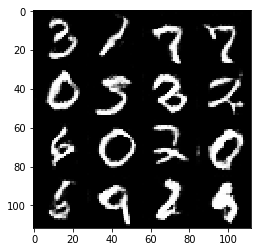

Epoch 1/2... Discriminator Loss: 1.0052... Generator Loss: 0.7193
Epoch 1/2... Discriminator Loss: 2.0529... Generator Loss: 0.1848
Epoch 1/2... Discriminator Loss: 2.2841... Generator Loss: 0.1571
Epoch 1/2... Discriminator Loss: 0.9038... Generator Loss: 0.6829
Epoch 1/2... Discriminator Loss: 1.4157... Generator Loss: 0.3446
Epoch 1/2... Discriminator Loss: 1.2835... Generator Loss: 0.3747
Epoch 1/2... Discriminator Loss: 0.7334... Generator Loss: 0.7746
Epoch 1/2... Discriminator Loss: 0.2111... Generator Loss: 1.9800
Epoch 1/2... Discriminator Loss: 0.3243... Generator Loss: 1.9439
Epoch 1/2... Discriminator Loss: 1.6451... Generator Loss: 0.3021


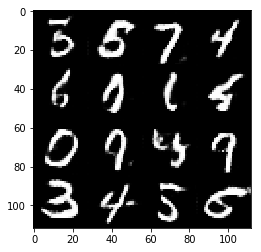

Epoch 1/2... Discriminator Loss: 0.7434... Generator Loss: 0.8462
Epoch 1/2... Discriminator Loss: 0.9152... Generator Loss: 0.6473
Epoch 1/2... Discriminator Loss: 1.7887... Generator Loss: 0.2160
Epoch 1/2... Discriminator Loss: 1.3572... Generator Loss: 0.4333
Epoch 1/2... Discriminator Loss: 2.5028... Generator Loss: 0.1543
Epoch 1/2... Discriminator Loss: 1.0779... Generator Loss: 0.7471
Epoch 1/2... Discriminator Loss: 1.7072... Generator Loss: 0.3757
Epoch 1/2... Discriminator Loss: 0.9370... Generator Loss: 0.6063
Epoch 1/2... Discriminator Loss: 0.9157... Generator Loss: 1.8367
Epoch 1/2... Discriminator Loss: 1.8671... Generator Loss: 0.2214


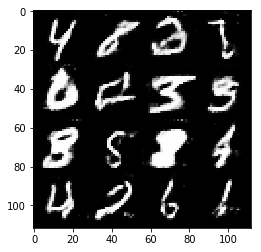

Epoch 1/2... Discriminator Loss: 0.5213... Generator Loss: 1.0120
Epoch 1/2... Discriminator Loss: 1.4558... Generator Loss: 0.3838
Epoch 1/2... Discriminator Loss: 1.5356... Generator Loss: 0.3582
Epoch 1/2... Discriminator Loss: 0.7992... Generator Loss: 0.7450
Epoch 1/2... Discriminator Loss: 1.8132... Generator Loss: 0.2878
Epoch 1/2... Discriminator Loss: 1.4035... Generator Loss: 0.3941
Epoch 1/2... Discriminator Loss: 1.6708... Generator Loss: 0.2640
Epoch 1/2... Discriminator Loss: 1.2512... Generator Loss: 0.4485
Epoch 1/2... Discriminator Loss: 2.4303... Generator Loss: 0.1060
Epoch 1/2... Discriminator Loss: 1.1039... Generator Loss: 0.6060


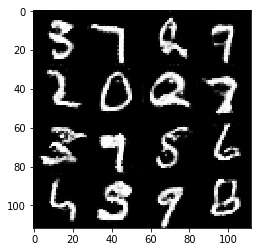

Epoch 1/2... Discriminator Loss: 1.1958... Generator Loss: 0.5239
Epoch 1/2... Discriminator Loss: 0.5909... Generator Loss: 1.0166
Epoch 1/2... Discriminator Loss: 0.6783... Generator Loss: 0.8048
Epoch 1/2... Discriminator Loss: 1.9300... Generator Loss: 0.2433
Epoch 1/2... Discriminator Loss: 0.6419... Generator Loss: 1.6380
Epoch 1/2... Discriminator Loss: 0.2139... Generator Loss: 2.4290
Epoch 1/2... Discriminator Loss: 0.4453... Generator Loss: 1.4451
Epoch 1/2... Discriminator Loss: 0.6527... Generator Loss: 1.6195
Epoch 1/2... Discriminator Loss: 0.2498... Generator Loss: 2.3119
Epoch 1/2... Discriminator Loss: 0.5386... Generator Loss: 1.2376


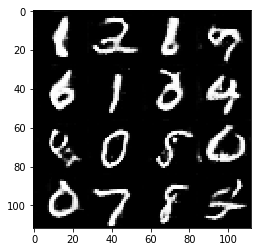

Epoch 1/2... Discriminator Loss: 1.5233... Generator Loss: 0.3810
Epoch 1/2... Discriminator Loss: 2.2453... Generator Loss: 0.1628
Epoch 1/2... Discriminator Loss: 0.2541... Generator Loss: 1.9883
Epoch 1/2... Discriminator Loss: 0.8619... Generator Loss: 0.6227
Epoch 1/2... Discriminator Loss: 1.2062... Generator Loss: 0.3926
Epoch 1/2... Discriminator Loss: 1.6788... Generator Loss: 0.2598
Epoch 1/2... Discriminator Loss: 0.4331... Generator Loss: 1.2565
Epoch 1/2... Discriminator Loss: 1.7003... Generator Loss: 0.2708
Epoch 1/2... Discriminator Loss: 2.4884... Generator Loss: 0.0977
Epoch 1/2... Discriminator Loss: 3.0964... Generator Loss: 0.0790


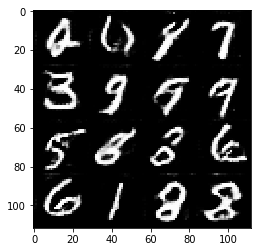

Epoch 1/2... Discriminator Loss: 1.2058... Generator Loss: 0.5378
Epoch 1/2... Discriminator Loss: 0.9752... Generator Loss: 0.7175
Epoch 1/2... Discriminator Loss: 1.0404... Generator Loss: 0.6336
Epoch 1/2... Discriminator Loss: 0.8329... Generator Loss: 0.8908
Epoch 1/2... Discriminator Loss: 2.4271... Generator Loss: 0.1029
Epoch 1/2... Discriminator Loss: 1.8132... Generator Loss: 0.3512
Epoch 1/2... Discriminator Loss: 1.5860... Generator Loss: 0.3598
Epoch 1/2... Discriminator Loss: 1.2758... Generator Loss: 0.3890
Epoch 1/2... Discriminator Loss: 1.8917... Generator Loss: 0.2112
Epoch 1/2... Discriminator Loss: 0.5996... Generator Loss: 1.0007


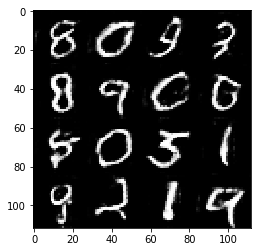

Epoch 1/2... Discriminator Loss: 0.6519... Generator Loss: 1.6646
Epoch 1/2... Discriminator Loss: 0.1406... Generator Loss: 2.3576
Epoch 1/2... Discriminator Loss: 1.5036... Generator Loss: 0.5814
Epoch 1/2... Discriminator Loss: 1.1197... Generator Loss: 0.6980
Epoch 1/2... Discriminator Loss: 1.4921... Generator Loss: 0.2725
Epoch 1/2... Discriminator Loss: 1.6578... Generator Loss: 0.2641
Epoch 1/2... Discriminator Loss: 1.9518... Generator Loss: 0.1959
Epoch 1/2... Discriminator Loss: 1.9856... Generator Loss: 0.1871
Epoch 1/2... Discriminator Loss: 0.0921... Generator Loss: 3.6189
Epoch 1/2... Discriminator Loss: 2.8036... Generator Loss: 0.0895


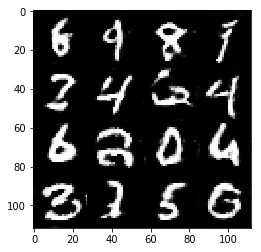

Epoch 1/2... Discriminator Loss: 1.5832... Generator Loss: 0.2975
Epoch 1/2... Discriminator Loss: 2.4460... Generator Loss: 0.1222
Epoch 1/2... Discriminator Loss: 0.6904... Generator Loss: 0.9364
Epoch 1/2... Discriminator Loss: 1.1474... Generator Loss: 0.5641
Epoch 1/2... Discriminator Loss: 0.8547... Generator Loss: 0.6637
Epoch 1/2... Discriminator Loss: 0.7772... Generator Loss: 0.8132
Epoch 1/2... Discriminator Loss: 0.9629... Generator Loss: 0.7187
Epoch 1/2... Discriminator Loss: 1.0750... Generator Loss: 0.7723
Epoch 1/2... Discriminator Loss: 1.4542... Generator Loss: 0.4111
Epoch 1/2... Discriminator Loss: 1.1866... Generator Loss: 0.5246


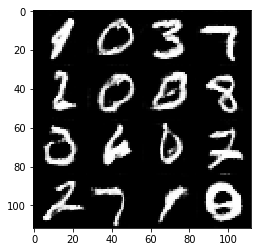

Epoch 1/2... Discriminator Loss: 0.4524... Generator Loss: 1.6441
Epoch 1/2... Discriminator Loss: 0.7529... Generator Loss: 0.9009
Epoch 1/2... Discriminator Loss: 0.9476... Generator Loss: 0.5905
Epoch 1/2... Discriminator Loss: 0.7993... Generator Loss: 0.7070
Epoch 1/2... Discriminator Loss: 3.4708... Generator Loss: 0.0473
Epoch 1/2... Discriminator Loss: 1.7046... Generator Loss: 0.2884
Epoch 1/2... Discriminator Loss: 1.3308... Generator Loss: 2.3355
Epoch 1/2... Discriminator Loss: 0.2278... Generator Loss: 2.1612
Epoch 1/2... Discriminator Loss: 1.8824... Generator Loss: 0.1974
Epoch 1/2... Discriminator Loss: 2.1620... Generator Loss: 0.1937


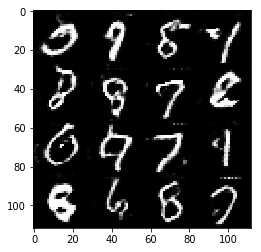

Epoch 1/2... Discriminator Loss: 0.9111... Generator Loss: 0.5991
Epoch 1/2... Discriminator Loss: 2.7355... Generator Loss: 0.1023
Epoch 1/2... Discriminator Loss: 2.4602... Generator Loss: 0.1127
Epoch 1/2... Discriminator Loss: 0.8118... Generator Loss: 0.7492
Epoch 1/2... Discriminator Loss: 1.8751... Generator Loss: 0.2047
Epoch 1/2... Discriminator Loss: 0.8495... Generator Loss: 0.9488
Epoch 1/2... Discriminator Loss: 0.5809... Generator Loss: 1.3714
Epoch 1/2... Discriminator Loss: 1.0170... Generator Loss: 1.1314
Epoch 1/2... Discriminator Loss: 1.4557... Generator Loss: 0.3746
Epoch 1/2... Discriminator Loss: 1.7388... Generator Loss: 0.2557


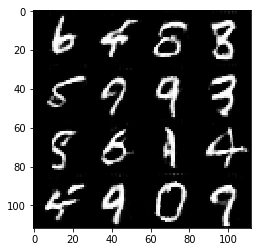

Epoch 1/2... Discriminator Loss: 0.9023... Generator Loss: 0.6486
Epoch 1/2... Discriminator Loss: 1.4481... Generator Loss: 0.3726
Epoch 1/2... Discriminator Loss: 2.0929... Generator Loss: 0.1675
Epoch 1/2... Discriminator Loss: 0.3245... Generator Loss: 1.5649
Epoch 1/2... Discriminator Loss: 2.2592... Generator Loss: 0.1624
Epoch 1/2... Discriminator Loss: 1.2529... Generator Loss: 0.3975
Epoch 1/2... Discriminator Loss: 1.2217... Generator Loss: 0.4696
Epoch 1/2... Discriminator Loss: 0.9530... Generator Loss: 0.6338
Epoch 1/2... Discriminator Loss: 1.2753... Generator Loss: 0.4448
Epoch 1/2... Discriminator Loss: 1.2393... Generator Loss: 0.4027


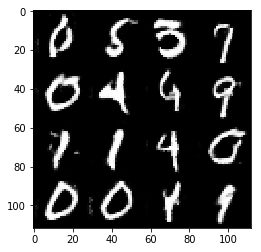

Epoch 1/2... Discriminator Loss: 0.6481... Generator Loss: 0.8640
Epoch 1/2... Discriminator Loss: 0.4262... Generator Loss: 1.3380
Epoch 1/2... Discriminator Loss: 0.5430... Generator Loss: 1.0991
Epoch 1/2... Discriminator Loss: 1.9361... Generator Loss: 0.1887
Epoch 1/2... Discriminator Loss: 0.6475... Generator Loss: 1.1591
Epoch 1/2... Discriminator Loss: 0.2357... Generator Loss: 2.4004
Epoch 1/2... Discriminator Loss: 1.2486... Generator Loss: 0.4371
Epoch 1/2... Discriminator Loss: 1.8711... Generator Loss: 0.2224
Epoch 1/2... Discriminator Loss: 1.2821... Generator Loss: 0.4247
Epoch 1/2... Discriminator Loss: 0.3677... Generator Loss: 1.7781


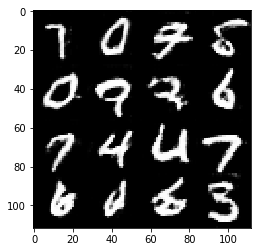

Epoch 1/2... Discriminator Loss: 0.6830... Generator Loss: 0.9407
Epoch 1/2... Discriminator Loss: 1.0170... Generator Loss: 0.5011
Epoch 1/2... Discriminator Loss: 1.6976... Generator Loss: 0.2612
Epoch 1/2... Discriminator Loss: 0.7933... Generator Loss: 0.7889
Epoch 1/2... Discriminator Loss: 1.3237... Generator Loss: 0.4020
Epoch 1/2... Discriminator Loss: 1.9135... Generator Loss: 0.2724
Epoch 1/2... Discriminator Loss: 1.2779... Generator Loss: 0.4702
Epoch 1/2... Discriminator Loss: 0.1568... Generator Loss: 2.6036
Epoch 1/2... Discriminator Loss: 0.7161... Generator Loss: 0.7641
Epoch 1/2... Discriminator Loss: 1.1400... Generator Loss: 0.5033


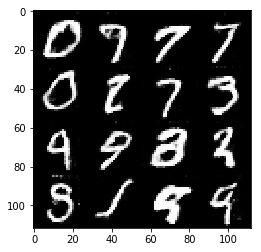

Epoch 2/2... Discriminator Loss: 0.6924... Generator Loss: 0.9196
Epoch 2/2... Discriminator Loss: 1.5369... Generator Loss: 0.3438
Epoch 2/2... Discriminator Loss: 2.1592... Generator Loss: 0.1430
Epoch 2/2... Discriminator Loss: 1.0374... Generator Loss: 0.6322
Epoch 2/2... Discriminator Loss: 0.5123... Generator Loss: 1.3903
Epoch 2/2... Discriminator Loss: 0.5101... Generator Loss: 1.6264
Epoch 2/2... Discriminator Loss: 1.1500... Generator Loss: 0.4703
Epoch 2/2... Discriminator Loss: 0.7955... Generator Loss: 0.7313
Epoch 2/2... Discriminator Loss: 0.9500... Generator Loss: 0.5804
Epoch 2/2... Discriminator Loss: 0.8709... Generator Loss: 0.9250


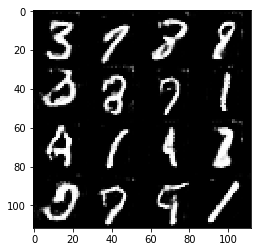

Epoch 2/2... Discriminator Loss: 1.5590... Generator Loss: 0.3162
Epoch 2/2... Discriminator Loss: 1.9734... Generator Loss: 0.2518
Epoch 2/2... Discriminator Loss: 1.2217... Generator Loss: 0.4256
Epoch 2/2... Discriminator Loss: 0.2454... Generator Loss: 1.9207
Epoch 2/2... Discriminator Loss: 1.6364... Generator Loss: 0.2673
Epoch 2/2... Discriminator Loss: 0.3971... Generator Loss: 1.6205
Epoch 2/2... Discriminator Loss: 0.7111... Generator Loss: 0.8328
Epoch 2/2... Discriminator Loss: 0.4681... Generator Loss: 1.1540
Epoch 2/2... Discriminator Loss: 0.4296... Generator Loss: 1.3379
Epoch 2/2... Discriminator Loss: 0.6617... Generator Loss: 1.1879


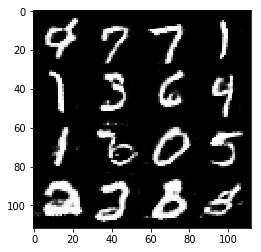

Epoch 2/2... Discriminator Loss: 0.6807... Generator Loss: 0.9666
Epoch 2/2... Discriminator Loss: 1.1973... Generator Loss: 0.4294
Epoch 2/2... Discriminator Loss: 3.9642... Generator Loss: 0.0330
Epoch 2/2... Discriminator Loss: 0.3414... Generator Loss: 2.0712
Epoch 2/2... Discriminator Loss: 0.7340... Generator Loss: 1.0334
Epoch 2/2... Discriminator Loss: 3.0667... Generator Loss: 0.0745
Epoch 2/2... Discriminator Loss: 1.0257... Generator Loss: 0.6855
Epoch 2/2... Discriminator Loss: 0.6683... Generator Loss: 0.9614
Epoch 2/2... Discriminator Loss: 0.7539... Generator Loss: 0.9163
Epoch 2/2... Discriminator Loss: 0.5971... Generator Loss: 2.2737


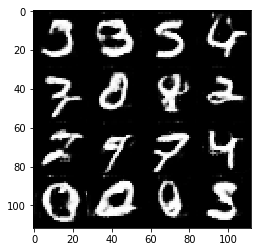

Epoch 2/2... Discriminator Loss: 1.9744... Generator Loss: 0.1787
Epoch 2/2... Discriminator Loss: 0.2554... Generator Loss: 3.7218
Epoch 2/2... Discriminator Loss: 1.9012... Generator Loss: 0.2695
Epoch 2/2... Discriminator Loss: 0.5900... Generator Loss: 1.0564
Epoch 2/2... Discriminator Loss: 2.1726... Generator Loss: 0.1700
Epoch 2/2... Discriminator Loss: 1.4012... Generator Loss: 0.3751
Epoch 2/2... Discriminator Loss: 0.5024... Generator Loss: 1.3756
Epoch 2/2... Discriminator Loss: 1.8702... Generator Loss: 0.2295
Epoch 2/2... Discriminator Loss: 1.0457... Generator Loss: 0.6799
Epoch 2/2... Discriminator Loss: 0.9356... Generator Loss: 0.7058


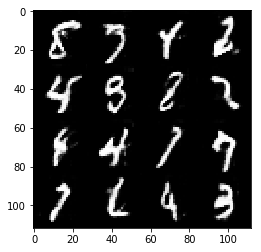

Epoch 2/2... Discriminator Loss: 2.3887... Generator Loss: 0.1251
Epoch 2/2... Discriminator Loss: 3.3915... Generator Loss: 0.0392
Epoch 2/2... Discriminator Loss: 0.2552... Generator Loss: 2.5444
Epoch 2/2... Discriminator Loss: 0.4424... Generator Loss: 1.2921
Epoch 2/2... Discriminator Loss: 0.8707... Generator Loss: 0.7118
Epoch 2/2... Discriminator Loss: 0.6406... Generator Loss: 1.0230
Epoch 2/2... Discriminator Loss: 1.8100... Generator Loss: 0.2658
Epoch 2/2... Discriminator Loss: 0.2712... Generator Loss: 1.9771
Epoch 2/2... Discriminator Loss: 1.1357... Generator Loss: 0.4906
Epoch 2/2... Discriminator Loss: 2.5895... Generator Loss: 0.1091


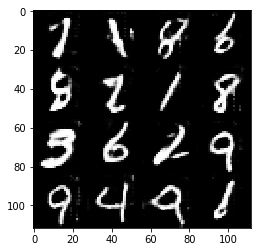

Epoch 2/2... Discriminator Loss: 1.1329... Generator Loss: 0.4814
Epoch 2/2... Discriminator Loss: 0.9620... Generator Loss: 0.6197
Epoch 2/2... Discriminator Loss: 0.6764... Generator Loss: 1.2238
Epoch 2/2... Discriminator Loss: 0.6401... Generator Loss: 0.9756
Epoch 2/2... Discriminator Loss: 1.7870... Generator Loss: 0.2075
Epoch 2/2... Discriminator Loss: 1.0804... Generator Loss: 1.3741
Epoch 2/2... Discriminator Loss: 0.5230... Generator Loss: 1.0894
Epoch 2/2... Discriminator Loss: 1.3494... Generator Loss: 0.3950
Epoch 2/2... Discriminator Loss: 1.9676... Generator Loss: 0.2160
Epoch 2/2... Discriminator Loss: 0.7377... Generator Loss: 0.8371


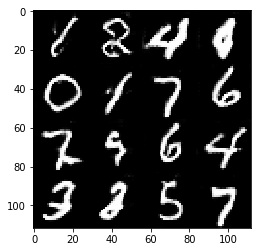

Epoch 2/2... Discriminator Loss: 0.6941... Generator Loss: 0.8304
Epoch 2/2... Discriminator Loss: 2.1429... Generator Loss: 0.2182
Epoch 2/2... Discriminator Loss: 0.8279... Generator Loss: 0.9350
Epoch 2/2... Discriminator Loss: 0.8786... Generator Loss: 0.7095
Epoch 2/2... Discriminator Loss: 1.4934... Generator Loss: 0.3179
Epoch 2/2... Discriminator Loss: 0.2550... Generator Loss: 1.9547
Epoch 2/2... Discriminator Loss: 0.1603... Generator Loss: 2.4334
Epoch 2/2... Discriminator Loss: 1.7049... Generator Loss: 0.2676
Epoch 2/2... Discriminator Loss: 0.4434... Generator Loss: 1.1386
Epoch 2/2... Discriminator Loss: 3.0321... Generator Loss: 0.0835


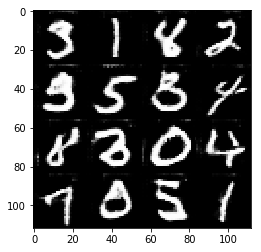

Epoch 2/2... Discriminator Loss: 1.1414... Generator Loss: 0.4763
Epoch 2/2... Discriminator Loss: 0.6107... Generator Loss: 0.8922
Epoch 2/2... Discriminator Loss: 1.7068... Generator Loss: 0.2859
Epoch 2/2... Discriminator Loss: 0.4171... Generator Loss: 1.5525
Epoch 2/2... Discriminator Loss: 0.7511... Generator Loss: 0.7337
Epoch 2/2... Discriminator Loss: 2.0335... Generator Loss: 0.1598
Epoch 2/2... Discriminator Loss: 0.9032... Generator Loss: 0.6525
Epoch 2/2... Discriminator Loss: 1.3923... Generator Loss: 0.3828
Epoch 2/2... Discriminator Loss: 2.6328... Generator Loss: 0.1090
Epoch 2/2... Discriminator Loss: 0.7007... Generator Loss: 0.8053


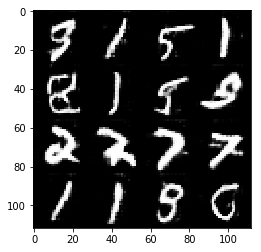

Epoch 2/2... Discriminator Loss: 2.3460... Generator Loss: 0.1935
Epoch 2/2... Discriminator Loss: 0.6884... Generator Loss: 0.9213
Epoch 2/2... Discriminator Loss: 0.9650... Generator Loss: 0.7057
Epoch 2/2... Discriminator Loss: 1.0043... Generator Loss: 0.4675
Epoch 2/2... Discriminator Loss: 1.0052... Generator Loss: 0.5735
Epoch 2/2... Discriminator Loss: 1.8559... Generator Loss: 0.2139
Epoch 2/2... Discriminator Loss: 1.3443... Generator Loss: 0.3797
Epoch 2/2... Discriminator Loss: 2.6314... Generator Loss: 0.1006
Epoch 2/2... Discriminator Loss: 0.5557... Generator Loss: 1.0700
Epoch 2/2... Discriminator Loss: 0.6850... Generator Loss: 1.0484


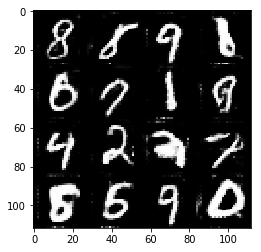

Epoch 2/2... Discriminator Loss: 1.0644... Generator Loss: 0.5344
Epoch 2/2... Discriminator Loss: 0.2218... Generator Loss: 2.7689
Epoch 2/2... Discriminator Loss: 1.0557... Generator Loss: 0.6981
Epoch 2/2... Discriminator Loss: 2.8353... Generator Loss: 0.1430
Epoch 2/2... Discriminator Loss: 1.3721... Generator Loss: 0.3798
Epoch 2/2... Discriminator Loss: 0.6294... Generator Loss: 0.9523
Epoch 2/2... Discriminator Loss: 1.3987... Generator Loss: 0.4017
Epoch 2/2... Discriminator Loss: 0.7862... Generator Loss: 0.8756
Epoch 2/2... Discriminator Loss: 1.9996... Generator Loss: 0.1814
Epoch 2/2... Discriminator Loss: 0.4823... Generator Loss: 1.4671


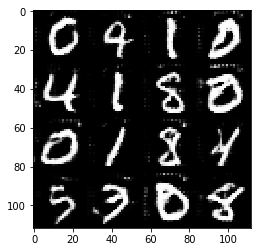

Epoch 2/2... Discriminator Loss: 1.5864... Generator Loss: 0.2992
Epoch 2/2... Discriminator Loss: 0.5776... Generator Loss: 1.3094
Epoch 2/2... Discriminator Loss: 0.1577... Generator Loss: 3.0592
Epoch 2/2... Discriminator Loss: 0.8732... Generator Loss: 0.7561
Epoch 2/2... Discriminator Loss: 0.9216... Generator Loss: 0.7119
Epoch 2/2... Discriminator Loss: 1.0759... Generator Loss: 0.7432
Epoch 2/2... Discriminator Loss: 0.6486... Generator Loss: 0.9154
Epoch 2/2... Discriminator Loss: 1.6026... Generator Loss: 0.3165
Epoch 2/2... Discriminator Loss: 0.5583... Generator Loss: 1.2598
Epoch 2/2... Discriminator Loss: 0.8208... Generator Loss: 1.5486


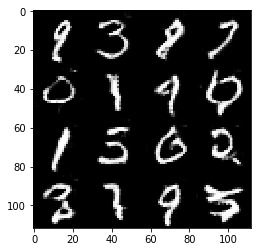

Epoch 2/2... Discriminator Loss: 0.2823... Generator Loss: 1.4967
Epoch 2/2... Discriminator Loss: 0.5071... Generator Loss: 1.1361
Epoch 2/2... Discriminator Loss: 0.4675... Generator Loss: 2.2681
Epoch 2/2... Discriminator Loss: 2.2445... Generator Loss: 0.1456
Epoch 2/2... Discriminator Loss: 0.8245... Generator Loss: 0.9799
Epoch 2/2... Discriminator Loss: 0.6822... Generator Loss: 0.8463
Epoch 2/2... Discriminator Loss: 0.1531... Generator Loss: 2.2927
Epoch 2/2... Discriminator Loss: 0.8817... Generator Loss: 0.6903
Epoch 2/2... Discriminator Loss: 1.0246... Generator Loss: 0.6080
Epoch 2/2... Discriminator Loss: 0.6142... Generator Loss: 1.1160


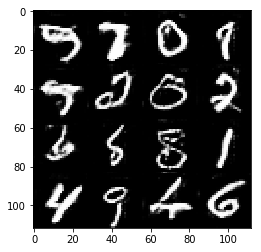

Epoch 2/2... Discriminator Loss: 0.4193... Generator Loss: 1.1755
Epoch 2/2... Discriminator Loss: 0.2314... Generator Loss: 1.9594
Epoch 2/2... Discriminator Loss: 0.2587... Generator Loss: 2.4702
Epoch 2/2... Discriminator Loss: 0.5439... Generator Loss: 1.2647
Epoch 2/2... Discriminator Loss: 1.3859... Generator Loss: 0.4317
Epoch 2/2... Discriminator Loss: 1.2439... Generator Loss: 0.5144
Epoch 2/2... Discriminator Loss: 0.7523... Generator Loss: 0.7751
Epoch 2/2... Discriminator Loss: 1.2626... Generator Loss: 0.4492
Epoch 2/2... Discriminator Loss: 0.2515... Generator Loss: 2.2861
Epoch 2/2... Discriminator Loss: 0.7402... Generator Loss: 0.8443


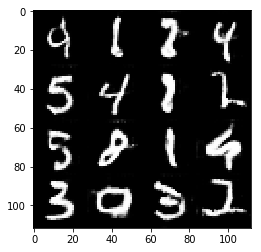

Epoch 2/2... Discriminator Loss: 1.8346... Generator Loss: 0.2001
Epoch 2/2... Discriminator Loss: 1.8499... Generator Loss: 0.3562
Epoch 2/2... Discriminator Loss: 0.8691... Generator Loss: 5.1271
Epoch 2/2... Discriminator Loss: 0.6251... Generator Loss: 0.9350
Epoch 2/2... Discriminator Loss: 0.3073... Generator Loss: 1.7807
Epoch 2/2... Discriminator Loss: 1.2495... Generator Loss: 0.4542
Epoch 2/2... Discriminator Loss: 0.6366... Generator Loss: 1.0910
Epoch 2/2... Discriminator Loss: 1.3298... Generator Loss: 0.4909
Epoch 2/2... Discriminator Loss: 0.9432... Generator Loss: 0.9920
Epoch 2/2... Discriminator Loss: 1.2884... Generator Loss: 0.3928


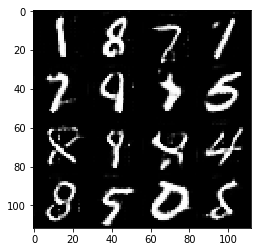

Epoch 2/2... Discriminator Loss: 0.4731... Generator Loss: 1.0623
Epoch 2/2... Discriminator Loss: 1.4057... Generator Loss: 0.3614
Epoch 2/2... Discriminator Loss: 1.0350... Generator Loss: 0.8354
Epoch 2/2... Discriminator Loss: 0.4937... Generator Loss: 1.2251
Epoch 2/2... Discriminator Loss: 0.8337... Generator Loss: 0.7815
Epoch 2/2... Discriminator Loss: 0.7034... Generator Loss: 0.9658
Epoch 2/2... Discriminator Loss: 0.7633... Generator Loss: 1.1897
Epoch 2/2... Discriminator Loss: 1.0723... Generator Loss: 0.5590
Epoch 2/2... Discriminator Loss: 0.2288... Generator Loss: 2.3052
Epoch 2/2... Discriminator Loss: 1.9614... Generator Loss: 0.2026


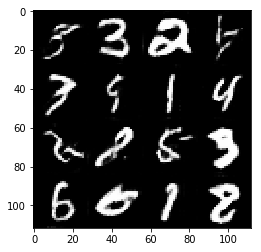

Epoch 2/2... Discriminator Loss: 0.7547... Generator Loss: 0.8668
Epoch 2/2... Discriminator Loss: 1.5761... Generator Loss: 0.3358
Epoch 2/2... Discriminator Loss: 0.3998... Generator Loss: 1.3707
Epoch 2/2... Discriminator Loss: 1.4176... Generator Loss: 0.3278
Epoch 2/2... Discriminator Loss: 0.8465... Generator Loss: 0.6398
Epoch 2/2... Discriminator Loss: 0.7498... Generator Loss: 0.7983
Epoch 2/2... Discriminator Loss: 1.8287... Generator Loss: 0.3316
Epoch 2/2... Discriminator Loss: 0.9210... Generator Loss: 0.6514
Epoch 2/2... Discriminator Loss: 0.9313... Generator Loss: 0.7897
Epoch 2/2... Discriminator Loss: 1.3758... Generator Loss: 0.3634


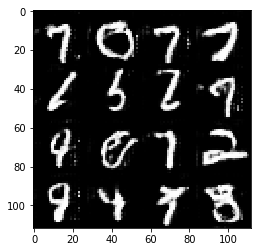

Epoch 2/2... Discriminator Loss: 0.3990... Generator Loss: 2.9764
Epoch 2/2... Discriminator Loss: 2.5122... Generator Loss: 0.1439
Epoch 2/2... Discriminator Loss: 0.3916... Generator Loss: 1.3102
Epoch 2/2... Discriminator Loss: 0.8380... Generator Loss: 0.9625
Epoch 2/2... Discriminator Loss: 1.0837... Generator Loss: 0.6290
Epoch 2/2... Discriminator Loss: 1.1432... Generator Loss: 0.4508
Epoch 2/2... Discriminator Loss: 3.1897... Generator Loss: 0.0640
Epoch 2/2... Discriminator Loss: 1.1188... Generator Loss: 0.4401
Epoch 2/2... Discriminator Loss: 0.8084... Generator Loss: 0.7654
Epoch 2/2... Discriminator Loss: 0.8382... Generator Loss: 0.6585


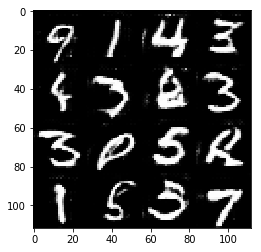

Epoch 2/2... Discriminator Loss: 0.5155... Generator Loss: 1.1090
Epoch 2/2... Discriminator Loss: 1.4969... Generator Loss: 0.4017
Epoch 2/2... Discriminator Loss: 0.6582... Generator Loss: 1.1716
Epoch 2/2... Discriminator Loss: 1.7343... Generator Loss: 0.2470
Epoch 2/2... Discriminator Loss: 1.8173... Generator Loss: 0.2348
Epoch 2/2... Discriminator Loss: 1.2460... Generator Loss: 0.6412
Epoch 2/2... Discriminator Loss: 0.4542... Generator Loss: 1.1449
Epoch 2/2... Discriminator Loss: 0.7692... Generator Loss: 3.7263
Epoch 2/2... Discriminator Loss: 0.8322... Generator Loss: 0.6436
Epoch 2/2... Discriminator Loss: 2.3662... Generator Loss: 0.1423


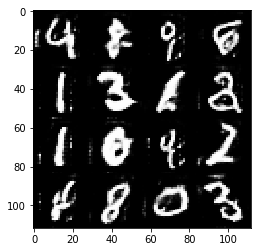

Epoch 2/2... Discriminator Loss: 2.1523... Generator Loss: 0.1765
Epoch 2/2... Discriminator Loss: 1.8469... Generator Loss: 0.3692
Epoch 2/2... Discriminator Loss: 0.7172... Generator Loss: 0.9953
Epoch 2/2... Discriminator Loss: 0.2295... Generator Loss: 2.5739
Epoch 2/2... Discriminator Loss: 2.3929... Generator Loss: 0.3225
Epoch 2/2... Discriminator Loss: 0.7404... Generator Loss: 0.8687
Epoch 2/2... Discriminator Loss: 0.1640... Generator Loss: 3.4014
Epoch 2/2... Discriminator Loss: 2.6043... Generator Loss: 0.0897
Epoch 2/2... Discriminator Loss: 2.1742... Generator Loss: 0.1381
Epoch 2/2... Discriminator Loss: 1.2036... Generator Loss: 0.6749


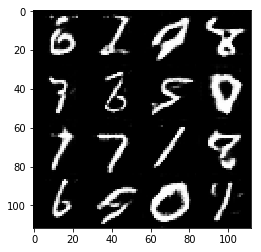

Epoch 2/2... Discriminator Loss: 1.8212... Generator Loss: 0.2298
Epoch 2/2... Discriminator Loss: 2.2316... Generator Loss: 0.1839
Epoch 2/2... Discriminator Loss: 1.0737... Generator Loss: 0.5502
Epoch 2/2... Discriminator Loss: 0.4622... Generator Loss: 1.4021
Epoch 2/2... Discriminator Loss: 0.5061... Generator Loss: 1.0079
Epoch 2/2... Discriminator Loss: 1.3492... Generator Loss: 0.3430
Epoch 2/2... Discriminator Loss: 0.8682... Generator Loss: 0.9233
Epoch 2/2... Discriminator Loss: 2.2905... Generator Loss: 0.1678
Epoch 2/2... Discriminator Loss: 2.1809... Generator Loss: 0.2714
Epoch 2/2... Discriminator Loss: 1.0760... Generator Loss: 0.5079


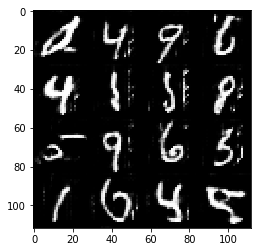

Epoch 2/2... Discriminator Loss: 1.4993... Generator Loss: 0.5145
Epoch 2/2... Discriminator Loss: 1.5624... Generator Loss: 0.2593
Epoch 2/2... Discriminator Loss: 1.2982... Generator Loss: 0.4285
Epoch 2/2... Discriminator Loss: 2.3493... Generator Loss: 0.1946
Epoch 2/2... Discriminator Loss: 2.2498... Generator Loss: 0.1757
Epoch 2/2... Discriminator Loss: 0.6971... Generator Loss: 0.9587
Epoch 2/2... Discriminator Loss: 0.6562... Generator Loss: 1.0538
Epoch 2/2... Discriminator Loss: 0.5915... Generator Loss: 1.0942
Epoch 2/2... Discriminator Loss: 1.5233... Generator Loss: 0.2875
Epoch 2/2... Discriminator Loss: 0.4754... Generator Loss: 1.1959


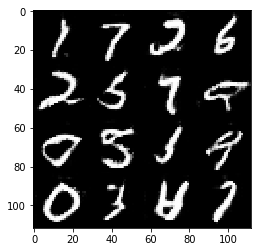

Epoch 2/2... Discriminator Loss: 0.4665... Generator Loss: 1.3567
Epoch 2/2... Discriminator Loss: 0.7566... Generator Loss: 0.9161
Epoch 2/2... Discriminator Loss: 0.8339... Generator Loss: 0.8548
Epoch 2/2... Discriminator Loss: 1.0379... Generator Loss: 0.5096
Epoch 2/2... Discriminator Loss: 1.4743... Generator Loss: 0.3284
Epoch 2/2... Discriminator Loss: 0.5721... Generator Loss: 1.1589
Epoch 2/2... Discriminator Loss: 1.3157... Generator Loss: 0.3945
Epoch 2/2... Discriminator Loss: 2.2805... Generator Loss: 0.1414
Epoch 2/2... Discriminator Loss: 0.3027... Generator Loss: 1.8083
Epoch 2/2... Discriminator Loss: 0.2648... Generator Loss: 1.8778


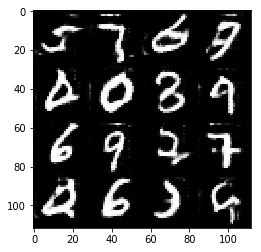

Epoch 2/2... Discriminator Loss: 0.5889... Generator Loss: 1.1564
Epoch 2/2... Discriminator Loss: 0.7311... Generator Loss: 0.7751
Epoch 2/2... Discriminator Loss: 0.2615... Generator Loss: 1.7800
Epoch 2/2... Discriminator Loss: 0.9867... Generator Loss: 0.5270
Epoch 2/2... Discriminator Loss: 1.3212... Generator Loss: 0.3662
Epoch 2/2... Discriminator Loss: 2.2670... Generator Loss: 0.1509
Epoch 2/2... Discriminator Loss: 0.3242... Generator Loss: 1.3802
Epoch 2/2... Discriminator Loss: 0.2608... Generator Loss: 1.7819
Epoch 2/2... Discriminator Loss: 1.4151... Generator Loss: 0.5595
Epoch 2/2... Discriminator Loss: 1.1525... Generator Loss: 0.4780


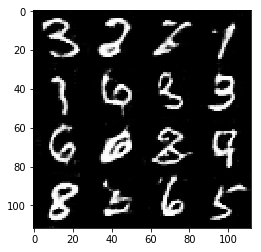

Epoch 2/2... Discriminator Loss: 1.6230... Generator Loss: 0.2431
Epoch 2/2... Discriminator Loss: 0.9239... Generator Loss: 0.6350
Epoch 2/2... Discriminator Loss: 0.4257... Generator Loss: 1.5392
Epoch 2/2... Discriminator Loss: 1.7827... Generator Loss: 0.2383
Epoch 2/2... Discriminator Loss: 1.1774... Generator Loss: 0.4636
Epoch 2/2... Discriminator Loss: 0.1492... Generator Loss: 2.7611
Epoch 2/2... Discriminator Loss: 1.5312... Generator Loss: 0.2873
Epoch 2/2... Discriminator Loss: 0.5136... Generator Loss: 1.1693
Epoch 2/2... Discriminator Loss: 0.6951... Generator Loss: 0.7852
Epoch 2/2... Discriminator Loss: 0.3663... Generator Loss: 1.5646


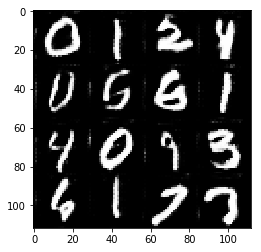

Epoch 2/2... Discriminator Loss: 1.5048... Generator Loss: 0.3103
Epoch 2/2... Discriminator Loss: 3.0826... Generator Loss: 0.0508
Epoch 2/2... Discriminator Loss: 0.6149... Generator Loss: 1.1287
Epoch 2/2... Discriminator Loss: 1.0876... Generator Loss: 0.4684
Epoch 2/2... Discriminator Loss: 2.4221... Generator Loss: 0.1103
Epoch 2/2... Discriminator Loss: 1.5756... Generator Loss: 0.2849
Epoch 2/2... Discriminator Loss: 0.8339... Generator Loss: 0.6639
Epoch 2/2... Discriminator Loss: 0.5104... Generator Loss: 1.1845
Epoch 2/2... Discriminator Loss: 0.1243... Generator Loss: 2.5807
Epoch 2/2... Discriminator Loss: 0.9598... Generator Loss: 0.6322


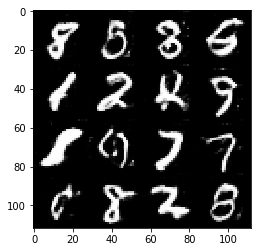

Epoch 2/2... Discriminator Loss: 1.2508... Generator Loss: 0.4281
Epoch 2/2... Discriminator Loss: 0.5220... Generator Loss: 1.2349
Epoch 2/2... Discriminator Loss: 0.8763... Generator Loss: 0.8353
Epoch 2/2... Discriminator Loss: 1.0362... Generator Loss: 1.8945
Epoch 2/2... Discriminator Loss: 1.4318... Generator Loss: 0.3355
Epoch 2/2... Discriminator Loss: 2.4267... Generator Loss: 0.1204
Epoch 2/2... Discriminator Loss: 0.2559... Generator Loss: 1.8953
Epoch 2/2... Discriminator Loss: 0.6580... Generator Loss: 0.8902
Epoch 2/2... Discriminator Loss: 0.7397... Generator Loss: 0.7399
Epoch 2/2... Discriminator Loss: 1.7276... Generator Loss: 0.2575


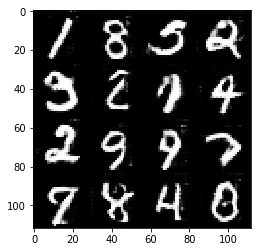

Epoch 2/2... Discriminator Loss: 1.5470... Generator Loss: 0.3338
Epoch 2/2... Discriminator Loss: 0.8059... Generator Loss: 0.6925
Epoch 2/2... Discriminator Loss: 0.6329... Generator Loss: 1.0098
Epoch 2/2... Discriminator Loss: 1.9726... Generator Loss: 0.2200
Epoch 2/2... Discriminator Loss: 1.9707... Generator Loss: 0.2080
Epoch 2/2... Discriminator Loss: 1.4350... Generator Loss: 0.4535
Epoch 2/2... Discriminator Loss: 2.0443... Generator Loss: 0.2169
Epoch 2/2... Discriminator Loss: 0.7056... Generator Loss: 0.7920
Epoch 2/2... Discriminator Loss: 0.3268... Generator Loss: 1.7311
Epoch 2/2... Discriminator Loss: 1.2231... Generator Loss: 0.4375


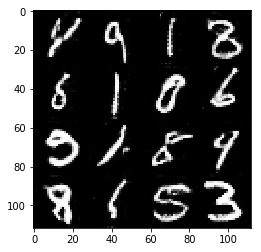

Epoch 2/2... Discriminator Loss: 0.8037... Generator Loss: 0.7077
Epoch 2/2... Discriminator Loss: 0.4222... Generator Loss: 1.7159
Epoch 2/2... Discriminator Loss: 0.0723... Generator Loss: 3.3363
Epoch 2/2... Discriminator Loss: 1.4605... Generator Loss: 0.3752
Epoch 2/2... Discriminator Loss: 1.3933... Generator Loss: 0.4281
Epoch 2/2... Discriminator Loss: 0.4699... Generator Loss: 1.5249
Epoch 2/2... Discriminator Loss: 1.0764... Generator Loss: 0.6021
Epoch 2/2... Discriminator Loss: 1.7932... Generator Loss: 0.2198
Epoch 2/2... Discriminator Loss: 0.2794... Generator Loss: 1.7348
Epoch 2/2... Discriminator Loss: 0.3594... Generator Loss: 1.8370


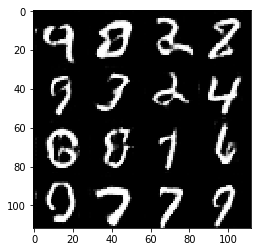

Epoch 2/2... Discriminator Loss: 1.9017... Generator Loss: 0.1949
Epoch 2/2... Discriminator Loss: 0.9680... Generator Loss: 0.6095
Epoch 2/2... Discriminator Loss: 0.2611... Generator Loss: 4.6639
Epoch 2/2... Discriminator Loss: 0.5506... Generator Loss: 1.2938
Epoch 2/2... Discriminator Loss: 1.2964... Generator Loss: 0.3907
Epoch 2/2... Discriminator Loss: 0.7814... Generator Loss: 0.8194
Epoch 2/2... Discriminator Loss: 1.9268... Generator Loss: 0.1838
Epoch 2/2... Discriminator Loss: 1.4273... Generator Loss: 0.4037
Epoch 2/2... Discriminator Loss: 0.5858... Generator Loss: 1.0499
Epoch 2/2... Discriminator Loss: 0.2071... Generator Loss: 1.9523


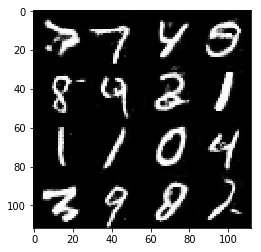

Epoch 2/2... Discriminator Loss: 0.3491... Generator Loss: 2.0652
Epoch 2/2... Discriminator Loss: 1.0379... Generator Loss: 0.6787
Epoch 2/2... Discriminator Loss: 1.7319... Generator Loss: 0.3266
Epoch 2/2... Discriminator Loss: 0.5497... Generator Loss: 1.0647
Epoch 2/2... Discriminator Loss: 0.0895... Generator Loss: 3.1500
Epoch 2/2... Discriminator Loss: 0.5558... Generator Loss: 0.9466
Epoch 2/2... Discriminator Loss: 0.8766... Generator Loss: 0.7079
Epoch 2/2... Discriminator Loss: 2.2277... Generator Loss: 0.1522
Epoch 2/2... Discriminator Loss: 0.4069... Generator Loss: 1.6399
Epoch 2/2... Discriminator Loss: 0.5191... Generator Loss: 0.9358


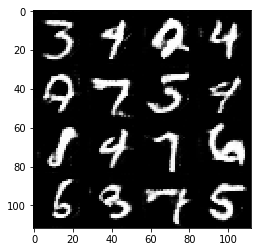

Epoch 2/2... Discriminator Loss: 0.5062... Generator Loss: 1.3916
Epoch 2/2... Discriminator Loss: 1.6952... Generator Loss: 0.3039
Epoch 2/2... Discriminator Loss: 1.4946... Generator Loss: 0.4369
Epoch 2/2... Discriminator Loss: 0.4828... Generator Loss: 1.3123
Epoch 2/2... Discriminator Loss: 1.6182... Generator Loss: 0.2841
Epoch 2/2... Discriminator Loss: 0.3199... Generator Loss: 1.7864
Epoch 2/2... Discriminator Loss: 0.5682... Generator Loss: 1.1895
Epoch 2/2... Discriminator Loss: 1.0932... Generator Loss: 0.5883
Epoch 2/2... Discriminator Loss: 2.0877... Generator Loss: 0.1908
Epoch 2/2... Discriminator Loss: 1.1222... Generator Loss: 0.4754


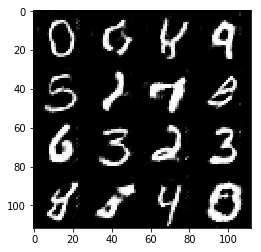

Epoch 2/2... Discriminator Loss: 2.9735... Generator Loss: 0.0833
Epoch 2/2... Discriminator Loss: 0.3442... Generator Loss: 1.4330
Epoch 2/2... Discriminator Loss: 0.3387... Generator Loss: 1.3627
Epoch 2/2... Discriminator Loss: 0.7479... Generator Loss: 0.8526
Epoch 2/2... Discriminator Loss: 0.7055... Generator Loss: 0.8178
Epoch 2/2... Discriminator Loss: 0.2691... Generator Loss: 1.9187
Epoch 2/2... Discriminator Loss: 0.9582... Generator Loss: 0.5823
Epoch 2/2... Discriminator Loss: 1.7220... Generator Loss: 0.2485
Epoch 2/2... Discriminator Loss: 1.6541... Generator Loss: 0.2886
Epoch 2/2... Discriminator Loss: 0.3195... Generator Loss: 1.5027


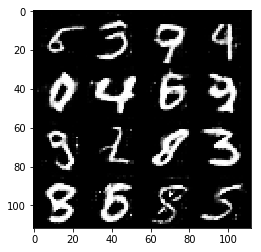

Epoch 2/2... Discriminator Loss: 0.2329... Generator Loss: 2.5970
Epoch 2/2... Discriminator Loss: 1.2553... Generator Loss: 0.3954
Epoch 2/2... Discriminator Loss: 1.3705... Generator Loss: 0.3147
Epoch 2/2... Discriminator Loss: 1.3307... Generator Loss: 0.4510
Epoch 2/2... Discriminator Loss: 1.5537... Generator Loss: 0.2775
Epoch 2/2... Discriminator Loss: 0.6790... Generator Loss: 0.9037
Epoch 2/2... Discriminator Loss: 0.3656... Generator Loss: 1.6122
Epoch 2/2... Discriminator Loss: 1.4692... Generator Loss: 0.3245
Epoch 2/2... Discriminator Loss: 1.0476... Generator Loss: 0.5872
Epoch 2/2... Discriminator Loss: 0.8837... Generator Loss: 0.9089


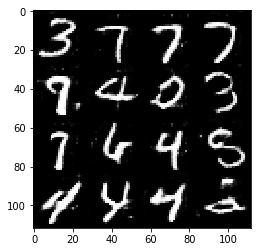

Epoch 2/2... Discriminator Loss: 0.3031... Generator Loss: 2.1669
Epoch 2/2... Discriminator Loss: 1.0568... Generator Loss: 0.5032
Epoch 2/2... Discriminator Loss: 0.2356... Generator Loss: 2.3331
Epoch 2/2... Discriminator Loss: 0.4945... Generator Loss: 3.2450
Epoch 2/2... Discriminator Loss: 1.8020... Generator Loss: 0.2882
Epoch 2/2... Discriminator Loss: 0.7515... Generator Loss: 0.8513
Epoch 2/2... Discriminator Loss: 1.9564... Generator Loss: 0.1863
Epoch 2/2... Discriminator Loss: 0.9713... Generator Loss: 0.5128
Epoch 2/2... Discriminator Loss: 2.0892... Generator Loss: 0.2112
Epoch 2/2... Discriminator Loss: 2.2659... Generator Loss: 0.1748


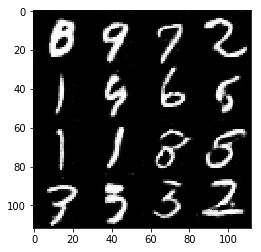

Epoch 2/2... Discriminator Loss: 0.3285... Generator Loss: 1.6513
Epoch 2/2... Discriminator Loss: 1.9437... Generator Loss: 0.2788
Epoch 2/2... Discriminator Loss: 0.2619... Generator Loss: 1.8773
Epoch 2/2... Discriminator Loss: 0.1616... Generator Loss: 2.4149
Epoch 2/2... Discriminator Loss: 2.1143... Generator Loss: 0.2794
Epoch 2/2... Discriminator Loss: 0.4489... Generator Loss: 1.2082
Epoch 2/2... Discriminator Loss: 0.5706... Generator Loss: 2.9521
Epoch 2/2... Discriminator Loss: 1.1294... Generator Loss: 0.5937
Epoch 2/2... Discriminator Loss: 0.5185... Generator Loss: 1.2024
Epoch 2/2... Discriminator Loss: 0.1613... Generator Loss: 2.3585


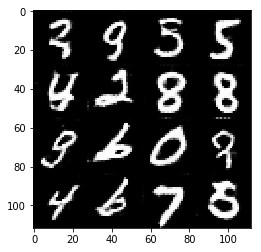

Epoch 2/2... Discriminator Loss: 0.6256... Generator Loss: 0.9581
Epoch 2/2... Discriminator Loss: 0.6478... Generator Loss: 1.0610
Epoch 2/2... Discriminator Loss: 0.4370... Generator Loss: 1.1724
Epoch 2/2... Discriminator Loss: 0.1466... Generator Loss: 2.2265
Epoch 2/2... Discriminator Loss: 0.5776... Generator Loss: 1.2766
Epoch 2/2... Discriminator Loss: 1.3426... Generator Loss: 0.4785
Epoch 2/2... Discriminator Loss: 2.3213... Generator Loss: 0.1454
Epoch 2/2... Discriminator Loss: 0.7554... Generator Loss: 0.9598
Epoch 2/2... Discriminator Loss: 0.8468... Generator Loss: 0.8794
Epoch 2/2... Discriminator Loss: 0.3605... Generator Loss: 1.3735


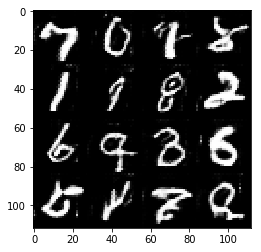

Epoch 2/2... Discriminator Loss: 3.0771... Generator Loss: 0.0597
Epoch 2/2... Discriminator Loss: 1.3146... Generator Loss: 0.3540
Epoch 2/2... Discriminator Loss: 0.5426... Generator Loss: 1.0023
Epoch 2/2... Discriminator Loss: 0.4253... Generator Loss: 1.2732
Epoch 2/2... Discriminator Loss: 1.4138... Generator Loss: 0.4844
Epoch 2/2... Discriminator Loss: 0.4267... Generator Loss: 1.4900
Epoch 2/2... Discriminator Loss: 0.7243... Generator Loss: 0.7496
Epoch 2/2... Discriminator Loss: 2.1475... Generator Loss: 0.1585
Epoch 2/2... Discriminator Loss: 0.1065... Generator Loss: 3.8309
Epoch 2/2... Discriminator Loss: 1.5676... Generator Loss: 0.4274


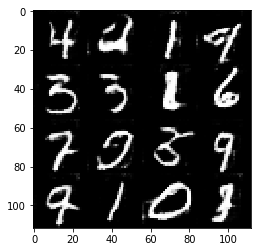

Epoch 2/2... Discriminator Loss: 0.8855... Generator Loss: 0.7561
Epoch 2/2... Discriminator Loss: 2.4511... Generator Loss: 0.1346
Epoch 2/2... Discriminator Loss: 0.7260... Generator Loss: 0.6920
Epoch 2/2... Discriminator Loss: 0.1522... Generator Loss: 2.4840
Epoch 2/2... Discriminator Loss: 2.2817... Generator Loss: 0.1492
Epoch 2/2... Discriminator Loss: 3.6006... Generator Loss: 0.0467
Epoch 2/2... Discriminator Loss: 0.5812... Generator Loss: 1.1104
Epoch 2/2... Discriminator Loss: 0.7235... Generator Loss: 0.9654
Epoch 2/2... Discriminator Loss: 0.3475... Generator Loss: 1.5064
Epoch 2/2... Discriminator Loss: 0.5381... Generator Loss: 1.2481


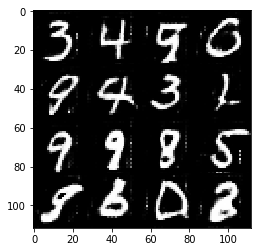

Epoch 2/2... Discriminator Loss: 1.4059... Generator Loss: 0.3204
Epoch 2/2... Discriminator Loss: 1.6185... Generator Loss: 0.2863
Epoch 2/2... Discriminator Loss: 0.6035... Generator Loss: 1.0056
Epoch 2/2... Discriminator Loss: 1.3525... Generator Loss: 0.9626
Epoch 2/2... Discriminator Loss: 0.4240... Generator Loss: 1.7892
Epoch 2/2... Discriminator Loss: 0.9265... Generator Loss: 0.5789
Epoch 2/2... Discriminator Loss: 0.4880... Generator Loss: 1.5683
Epoch 2/2... Discriminator Loss: 1.1310... Generator Loss: 0.4818
Epoch 2/2... Discriminator Loss: 0.2907... Generator Loss: 1.9776
Epoch 2/2... Discriminator Loss: 0.8424... Generator Loss: 0.9383


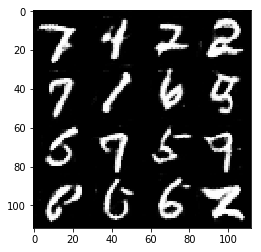

Epoch 2/2... Discriminator Loss: 0.9215... Generator Loss: 0.6934
Epoch 2/2... Discriminator Loss: 1.3915... Generator Loss: 0.3548
Epoch 2/2... Discriminator Loss: 1.4600... Generator Loss: 0.4541
Epoch 2/2... Discriminator Loss: 1.4897... Generator Loss: 0.3800
Epoch 2/2... Discriminator Loss: 1.3138... Generator Loss: 0.3987
Epoch 2/2... Discriminator Loss: 0.5854... Generator Loss: 1.2148
Epoch 2/2... Discriminator Loss: 0.8142... Generator Loss: 0.8813
Epoch 2/2... Discriminator Loss: 2.4638... Generator Loss: 0.2200
Epoch 2/2... Discriminator Loss: 2.6638... Generator Loss: 0.1254
Epoch 2/2... Discriminator Loss: 1.0533... Generator Loss: 0.7427


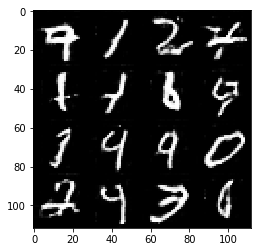

Epoch 2/2... Discriminator Loss: 3.1935... Generator Loss: 0.0846
Epoch 2/2... Discriminator Loss: 0.9454... Generator Loss: 0.6672
Epoch 2/2... Discriminator Loss: 0.7864... Generator Loss: 0.8764
Epoch 2/2... Discriminator Loss: 0.4552... Generator Loss: 1.3585
Epoch 2/2... Discriminator Loss: 1.1429... Generator Loss: 0.4759
Epoch 2/2... Discriminator Loss: 0.9087... Generator Loss: 0.6724
Epoch 2/2... Discriminator Loss: 0.6195... Generator Loss: 2.3631
Epoch 2/2... Discriminator Loss: 1.9839... Generator Loss: 0.1913
Epoch 2/2... Discriminator Loss: 0.2660... Generator Loss: 2.2627
Epoch 2/2... Discriminator Loss: 0.8003... Generator Loss: 0.6998


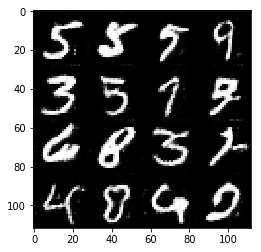

Epoch 2/2... Discriminator Loss: 0.3926... Generator Loss: 1.2417
Epoch 2/2... Discriminator Loss: 0.9024... Generator Loss: 0.8361
Epoch 2/2... Discriminator Loss: 0.4271... Generator Loss: 1.1403
Epoch 2/2... Discriminator Loss: 0.6603... Generator Loss: 0.9894
Epoch 2/2... Discriminator Loss: 0.3474... Generator Loss: 1.5631
Epoch 2/2... Discriminator Loss: 1.6521... Generator Loss: 0.4044
Epoch 2/2... Discriminator Loss: 1.0310... Generator Loss: 0.8458
Epoch 2/2... Discriminator Loss: 0.9414... Generator Loss: 0.6274
Epoch 2/2... Discriminator Loss: 0.2483... Generator Loss: 1.9637
Epoch 2/2... Discriminator Loss: 0.4110... Generator Loss: 1.4153


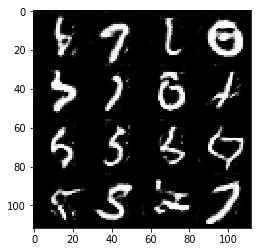

Epoch 2/2... Discriminator Loss: 1.0169... Generator Loss: 0.5263
Epoch 2/2... Discriminator Loss: 0.6041... Generator Loss: 0.9010
Epoch 2/2... Discriminator Loss: 0.7908... Generator Loss: 0.8982
Epoch 2/2... Discriminator Loss: 1.6915... Generator Loss: 0.3156
Epoch 2/2... Discriminator Loss: 2.0370... Generator Loss: 0.1904
Epoch 2/2... Discriminator Loss: 0.5218... Generator Loss: 1.1275
Epoch 2/2... Discriminator Loss: 1.8554... Generator Loss: 0.2646
Epoch 2/2... Discriminator Loss: 2.3336... Generator Loss: 0.1290
Epoch 2/2... Discriminator Loss: 0.3035... Generator Loss: 1.9512
Epoch 2/2... Discriminator Loss: 0.3415... Generator Loss: 1.4437


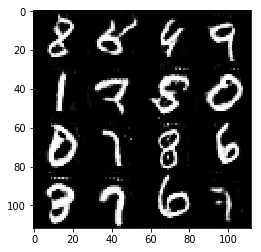

Epoch 2/2... Discriminator Loss: 1.3927... Generator Loss: 0.3117
Epoch 2/2... Discriminator Loss: 0.1011... Generator Loss: 2.8150
Epoch 2/2... Discriminator Loss: 1.6568... Generator Loss: 0.2621
Epoch 2/2... Discriminator Loss: 1.4149... Generator Loss: 0.4047
Epoch 2/2... Discriminator Loss: 0.7841... Generator Loss: 0.7751
Epoch 2/2... Discriminator Loss: 0.7716... Generator Loss: 0.7024
Epoch 2/2... Discriminator Loss: 1.1598... Generator Loss: 0.4694
Epoch 2/2... Discriminator Loss: 1.9701... Generator Loss: 0.1806
Epoch 2/2... Discriminator Loss: 1.4616... Generator Loss: 0.3577
Epoch 2/2... Discriminator Loss: 0.5851... Generator Loss: 1.1564


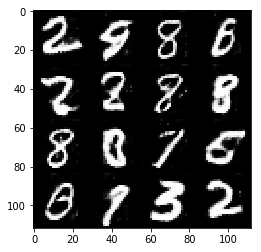

Epoch 2/2... Discriminator Loss: 0.8687... Generator Loss: 0.6162
Epoch 2/2... Discriminator Loss: 0.7889... Generator Loss: 0.7436
Epoch 2/2... Discriminator Loss: 1.1721... Generator Loss: 0.4483
Epoch 2/2... Discriminator Loss: 1.5100... Generator Loss: 0.2881
Epoch 2/2... Discriminator Loss: 0.0800... Generator Loss: 3.1512
Epoch 2/2... Discriminator Loss: 0.3129... Generator Loss: 1.4414
Epoch 2/2... Discriminator Loss: 2.2561... Generator Loss: 0.1529
Epoch 2/2... Discriminator Loss: 0.6174... Generator Loss: 0.9661
Epoch 2/2... Discriminator Loss: 0.5606... Generator Loss: 1.0493
Epoch 2/2... Discriminator Loss: 0.9626... Generator Loss: 0.5860


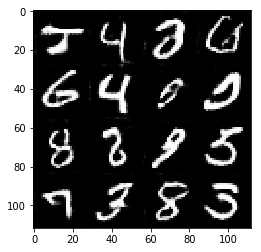

Epoch 2/2... Discriminator Loss: 1.1719... Generator Loss: 0.4378
Epoch 2/2... Discriminator Loss: 2.0101... Generator Loss: 0.1638
Epoch 2/2... Discriminator Loss: 1.7473... Generator Loss: 0.2482
Epoch 2/2... Discriminator Loss: 0.6496... Generator Loss: 0.9885
Epoch 2/2... Discriminator Loss: 0.6936... Generator Loss: 0.8711
Epoch 2/2... Discriminator Loss: 0.4901... Generator Loss: 1.4885
Epoch 2/2... Discriminator Loss: 0.2100... Generator Loss: 2.2095
Epoch 2/2... Discriminator Loss: 1.3858... Generator Loss: 0.4992
Epoch 2/2... Discriminator Loss: 0.7397... Generator Loss: 0.8382
Epoch 2/2... Discriminator Loss: 0.8393... Generator Loss: 0.6700


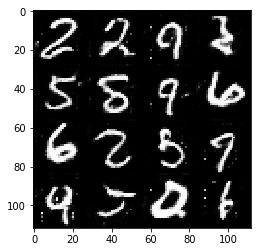

Epoch 2/2... Discriminator Loss: 0.4511... Generator Loss: 1.1831
Epoch 2/2... Discriminator Loss: 0.6120... Generator Loss: 1.0567
Epoch 2/2... Discriminator Loss: 0.0514... Generator Loss: 4.5402
Epoch 2/2... Discriminator Loss: 0.4371... Generator Loss: 1.1779
Epoch 2/2... Discriminator Loss: 1.1750... Generator Loss: 0.4900
Epoch 2/2... Discriminator Loss: 0.9758... Generator Loss: 0.5901
Epoch 2/2... Discriminator Loss: 1.0392... Generator Loss: 0.6695
Epoch 2/2... Discriminator Loss: 0.7246... Generator Loss: 0.7566
Epoch 2/2... Discriminator Loss: 0.5675... Generator Loss: 1.2002
Epoch 2/2... Discriminator Loss: 1.1100... Generator Loss: 0.5523


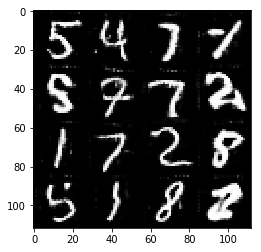

Epoch 2/2... Discriminator Loss: 1.5736... Generator Loss: 0.3142
Epoch 2/2... Discriminator Loss: 0.7163... Generator Loss: 0.8179
Epoch 2/2... Discriminator Loss: 1.0535... Generator Loss: 0.6323
Epoch 2/2... Discriminator Loss: 0.2035... Generator Loss: 2.7220
Epoch 2/2... Discriminator Loss: 0.4349... Generator Loss: 1.3347
Epoch 2/2... Discriminator Loss: 0.9048... Generator Loss: 0.8353
Epoch 2/2... Discriminator Loss: 0.6795... Generator Loss: 0.9517
Epoch 2/2... Discriminator Loss: 1.7410... Generator Loss: 0.3190
Epoch 2/2... Discriminator Loss: 0.6486... Generator Loss: 0.9410
Epoch 2/2... Discriminator Loss: 1.8801... Generator Loss: 0.2323


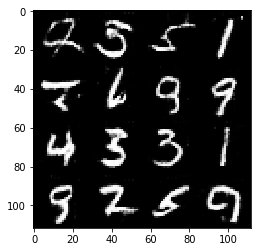

Epoch 2/2... Discriminator Loss: 0.3420... Generator Loss: 1.5255
Epoch 2/2... Discriminator Loss: 1.0948... Generator Loss: 0.5827
Epoch 2/2... Discriminator Loss: 0.3639... Generator Loss: 1.3818
Epoch 2/2... Discriminator Loss: 0.5318... Generator Loss: 1.4250
Epoch 2/2... Discriminator Loss: 0.8411... Generator Loss: 1.1653
Epoch 2/2... Discriminator Loss: 2.2765... Generator Loss: 0.1578
Epoch 2/2... Discriminator Loss: 0.9896... Generator Loss: 0.6978
Epoch 2/2... Discriminator Loss: 1.4905... Generator Loss: 0.3410
Epoch 2/2... Discriminator Loss: 1.5010... Generator Loss: 0.2929
Epoch 2/2... Discriminator Loss: 1.4033... Generator Loss: 0.3668


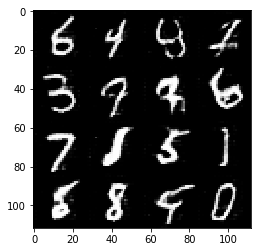

Epoch 2/2... Discriminator Loss: 0.5447... Generator Loss: 0.9473
Epoch 2/2... Discriminator Loss: 1.1398... Generator Loss: 0.5082
Epoch 2/2... Discriminator Loss: 2.6547... Generator Loss: 0.1057
Epoch 2/2... Discriminator Loss: 0.5716... Generator Loss: 1.2619
Epoch 2/2... Discriminator Loss: 2.0961... Generator Loss: 0.1803
Epoch 2/2... Discriminator Loss: 1.0699... Generator Loss: 0.7653
Epoch 2/2... Discriminator Loss: 0.6834... Generator Loss: 1.5088
Epoch 2/2... Discriminator Loss: 0.4883... Generator Loss: 1.3619
Epoch 2/2... Discriminator Loss: 1.9575... Generator Loss: 0.2449
Epoch 2/2... Discriminator Loss: 1.8402... Generator Loss: 0.2142


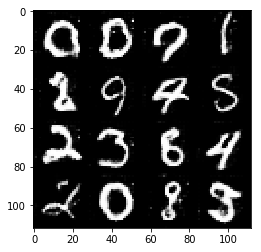

Epoch 2/2... Discriminator Loss: 0.6011... Generator Loss: 1.0974
Epoch 2/2... Discriminator Loss: 1.2294... Generator Loss: 0.4643
Epoch 2/2... Discriminator Loss: 0.3881... Generator Loss: 1.7647
Epoch 2/2... Discriminator Loss: 0.1783... Generator Loss: 2.5518
Epoch 2/2... Discriminator Loss: 0.9403... Generator Loss: 0.6471
Epoch 2/2... Discriminator Loss: 0.6080... Generator Loss: 1.1598
Epoch 2/2... Discriminator Loss: 2.0273... Generator Loss: 0.1728
Epoch 2/2... Discriminator Loss: 0.2114... Generator Loss: 2.3209
Epoch 2/2... Discriminator Loss: 1.1288... Generator Loss: 0.4571
Epoch 2/2... Discriminator Loss: 1.4667... Generator Loss: 0.5958


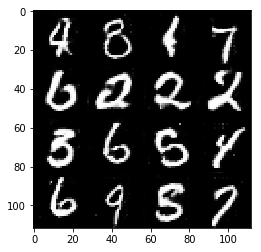

Epoch 2/2... Discriminator Loss: 1.3677... Generator Loss: 0.3445
Epoch 2/2... Discriminator Loss: 0.2642... Generator Loss: 1.7605
Epoch 2/2... Discriminator Loss: 0.8043... Generator Loss: 0.9131
Epoch 2/2... Discriminator Loss: 0.3908... Generator Loss: 1.6726
Epoch 2/2... Discriminator Loss: 0.7265... Generator Loss: 1.1162
Epoch 2/2... Discriminator Loss: 1.2758... Generator Loss: 0.4162
Epoch 2/2... Discriminator Loss: 0.3339... Generator Loss: 1.7911
Epoch 2/2... Discriminator Loss: 1.1023... Generator Loss: 0.5009
Epoch 2/2... Discriminator Loss: 0.8956... Generator Loss: 0.6061
Epoch 2/2... Discriminator Loss: 0.0947... Generator Loss: 2.8520


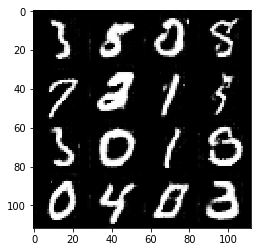

Epoch 2/2... Discriminator Loss: 1.7331... Generator Loss: 0.2850
Epoch 2/2... Discriminator Loss: 0.7556... Generator Loss: 0.7547
Epoch 2/2... Discriminator Loss: 1.4285... Generator Loss: 0.3029
Epoch 2/2... Discriminator Loss: 0.6659... Generator Loss: 0.8508
Epoch 2/2... Discriminator Loss: 1.8175... Generator Loss: 0.2912
Epoch 2/2... Discriminator Loss: 0.1582... Generator Loss: 2.4939
Epoch 2/2... Discriminator Loss: 0.2800... Generator Loss: 1.6449
Epoch 2/2... Discriminator Loss: 3.2894... Generator Loss: 0.0517
Epoch 2/2... Discriminator Loss: 0.4095... Generator Loss: 1.7139
Epoch 2/2... Discriminator Loss: 3.2556... Generator Loss: 0.1047


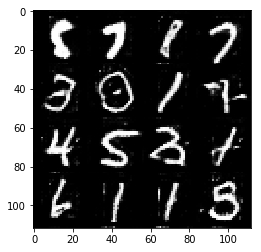

Epoch 2/2... Discriminator Loss: 0.2346... Generator Loss: 1.9630
Epoch 2/2... Discriminator Loss: 2.0098... Generator Loss: 0.3308
Epoch 2/2... Discriminator Loss: 1.4628... Generator Loss: 0.4052
Epoch 2/2... Discriminator Loss: 0.8572... Generator Loss: 0.7466
Epoch 2/2... Discriminator Loss: 1.5840... Generator Loss: 0.2932
Epoch 2/2... Discriminator Loss: 0.3289... Generator Loss: 1.7310
Epoch 2/2... Discriminator Loss: 0.2670... Generator Loss: 1.8856
Epoch 2/2... Discriminator Loss: 1.0350... Generator Loss: 0.5376
Epoch 2/2... Discriminator Loss: 1.4618... Generator Loss: 0.3420
Epoch 2/2... Discriminator Loss: 0.7404... Generator Loss: 0.9638


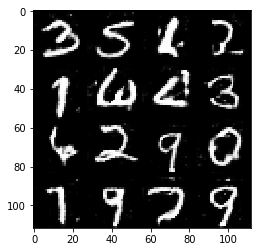

Epoch 2/2... Discriminator Loss: 0.4248... Generator Loss: 1.4173
Epoch 2/2... Discriminator Loss: 0.9248... Generator Loss: 0.6195
Epoch 2/2... Discriminator Loss: 2.9137... Generator Loss: 0.0856
Epoch 2/2... Discriminator Loss: 1.0251... Generator Loss: 0.5487
Epoch 2/2... Discriminator Loss: 0.4455... Generator Loss: 1.2319
Epoch 2/2... Discriminator Loss: 1.2235... Generator Loss: 0.4380
Epoch 2/2... Discriminator Loss: 0.3386... Generator Loss: 1.3427
Epoch 2/2... Discriminator Loss: 0.7196... Generator Loss: 1.0042
Epoch 2/2... Discriminator Loss: 0.5196... Generator Loss: 1.1982
Epoch 2/2... Discriminator Loss: 0.1471... Generator Loss: 2.6403


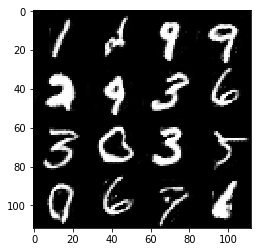

Epoch 2/2... Discriminator Loss: 2.7118... Generator Loss: 0.1452
Epoch 2/2... Discriminator Loss: 3.0354... Generator Loss: 0.1119
Epoch 2/2... Discriminator Loss: 1.1990... Generator Loss: 0.5069
Epoch 2/2... Discriminator Loss: 1.2354... Generator Loss: 0.4548
Epoch 2/2... Discriminator Loss: 0.6928... Generator Loss: 3.4275
Epoch 2/2... Discriminator Loss: 1.1403... Generator Loss: 0.4408
Epoch 2/2... Discriminator Loss: 2.2553... Generator Loss: 0.1516
Epoch 2/2... Discriminator Loss: 0.4874... Generator Loss: 1.0239
Epoch 2/2... Discriminator Loss: 1.3316... Generator Loss: 0.5079
Epoch 2/2... Discriminator Loss: 0.0704... Generator Loss: 3.6924


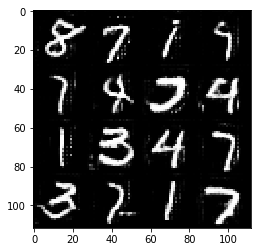

Epoch 2/2... Discriminator Loss: 0.2661... Generator Loss: 1.5670
Epoch 2/2... Discriminator Loss: 0.2654... Generator Loss: 4.7047
Epoch 2/2... Discriminator Loss: 0.9807... Generator Loss: 0.8208
Epoch 2/2... Discriminator Loss: 2.1774... Generator Loss: 0.1672
Epoch 2/2... Discriminator Loss: 0.4015... Generator Loss: 1.4318
Epoch 2/2... Discriminator Loss: 1.2812... Generator Loss: 0.5215
Epoch 2/2... Discriminator Loss: 3.2631... Generator Loss: 0.0477
Epoch 2/2... Discriminator Loss: 0.5834... Generator Loss: 1.1827
Epoch 2/2... Discriminator Loss: 2.6225... Generator Loss: 0.1053
Epoch 2/2... Discriminator Loss: 1.0395... Generator Loss: 0.5530


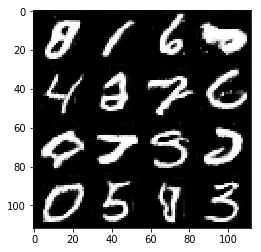

Epoch 2/2... Discriminator Loss: 0.3146... Generator Loss: 2.0024
Epoch 2/2... Discriminator Loss: 0.9419... Generator Loss: 0.6444
Epoch 2/2... Discriminator Loss: 1.4992... Generator Loss: 0.2940
Epoch 2/2... Discriminator Loss: 0.2034... Generator Loss: 2.0191
Epoch 2/2... Discriminator Loss: 1.1881... Generator Loss: 0.4812
Epoch 2/2... Discriminator Loss: 0.2053... Generator Loss: 2.1899
Epoch 2/2... Discriminator Loss: 1.4859... Generator Loss: 0.4221
Epoch 2/2... Discriminator Loss: 0.9863... Generator Loss: 0.6043
Epoch 2/2... Discriminator Loss: 0.6231... Generator Loss: 1.0489
Epoch 2/2... Discriminator Loss: 0.7305... Generator Loss: 1.6996


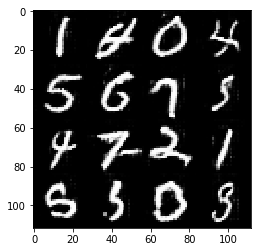

Epoch 2/2... Discriminator Loss: 0.2488... Generator Loss: 1.9470
Epoch 2/2... Discriminator Loss: 0.4158... Generator Loss: 1.3540
Epoch 2/2... Discriminator Loss: 0.4121... Generator Loss: 1.2836
Epoch 2/2... Discriminator Loss: 1.1898... Generator Loss: 0.4692
Epoch 2/2... Discriminator Loss: 0.1150... Generator Loss: 2.8466
Epoch 2/2... Discriminator Loss: 0.8934... Generator Loss: 0.6413
Epoch 2/2... Discriminator Loss: 0.6501... Generator Loss: 1.1895
Epoch 2/2... Discriminator Loss: 2.1813... Generator Loss: 0.1346
Epoch 2/2... Discriminator Loss: 0.4724... Generator Loss: 1.2085
Epoch 2/2... Discriminator Loss: 2.0038... Generator Loss: 0.1764


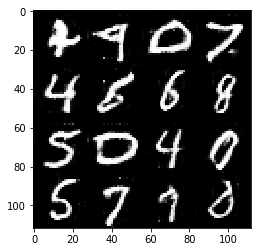

Epoch 2/2... Discriminator Loss: 1.4409... Generator Loss: 0.3097
Epoch 2/2... Discriminator Loss: 0.1185... Generator Loss: 2.5144
Epoch 2/2... Discriminator Loss: 0.5587... Generator Loss: 1.0450
Epoch 2/2... Discriminator Loss: 0.2944... Generator Loss: 1.8358
Epoch 2/2... Discriminator Loss: 0.0698... Generator Loss: 3.2590
Epoch 2/2... Discriminator Loss: 1.0690... Generator Loss: 0.5601
Epoch 2/2... Discriminator Loss: 0.4057... Generator Loss: 1.1732
Epoch 2/2... Discriminator Loss: 0.0807... Generator Loss: 3.8733
Epoch 2/2... Discriminator Loss: 1.4932... Generator Loss: 0.5392
Epoch 2/2... Discriminator Loss: 1.3275... Generator Loss: 0.4462


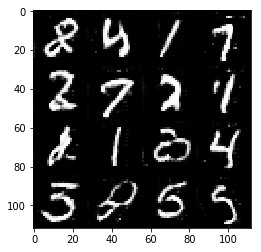

In [12]:
batch_size = 10
z_dim = 100 # 100 200 500
learning_rate = 0.001 # 0.0001 0.01 0.02 0.002 0.0002 0.00002 0.1 0.0004 0.0006 0.001
beta1 = 0.5 # 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.0773... Generator Loss: 9.1958
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.5694
Epoch 1/1... Discriminator Loss: 0.1489... Generator Loss: 3.5910
Epoch 1/1... Discriminator Loss: 1.5118... Generator Loss: 0.5130
Epoch 1/1... Discriminator Loss: 1.0559... Generator Loss: 1.1619
Epoch 1/1... Discriminator Loss: 0.8975... Generator Loss: 0.9050
Epoch 1/1... Discriminator Loss: 0.9546... Generator Loss: 0.8639
Epoch 1/1... Discriminator Loss: 0.9833... Generator Loss: 0.7631
Epoch 1/1... Discriminator Loss: 1.0399... Generator Loss: 0.7538
Epoch 1/1... Discriminator Loss: 1.6985... Generator Loss: 0.3263


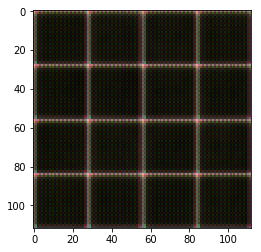

Epoch 1/1... Discriminator Loss: 1.0654... Generator Loss: 0.7158
Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 2.9058
Epoch 1/1... Discriminator Loss: 0.8120... Generator Loss: 1.7774
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.3678
Epoch 1/1... Discriminator Loss: 0.7937... Generator Loss: 2.0601
Epoch 1/1... Discriminator Loss: 2.2333... Generator Loss: 0.2016
Epoch 1/1... Discriminator Loss: 0.8191... Generator Loss: 1.9672
Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 0.5842
Epoch 1/1... Discriminator Loss: 0.8788... Generator Loss: 0.9001
Epoch 1/1... Discriminator Loss: 1.0359... Generator Loss: 1.6267


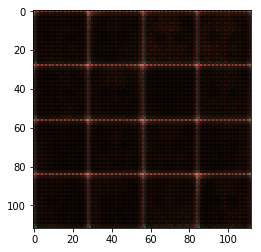

Epoch 1/1... Discriminator Loss: 0.9103... Generator Loss: 2.1121
Epoch 1/1... Discriminator Loss: 2.1688... Generator Loss: 0.1498
Epoch 1/1... Discriminator Loss: 0.8116... Generator Loss: 1.6433
Epoch 1/1... Discriminator Loss: 0.8704... Generator Loss: 0.8331
Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 0.4419
Epoch 1/1... Discriminator Loss: 1.0188... Generator Loss: 0.7007
Epoch 1/1... Discriminator Loss: 2.1100... Generator Loss: 0.1777
Epoch 1/1... Discriminator Loss: 1.1542... Generator Loss: 1.0926
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 1.3524
Epoch 1/1... Discriminator Loss: 1.0336... Generator Loss: 0.8219


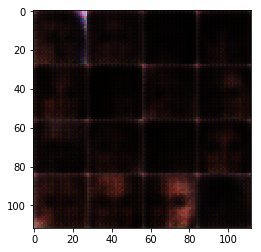

Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 0.9213
Epoch 1/1... Discriminator Loss: 1.2049... Generator Loss: 0.8139
Epoch 1/1... Discriminator Loss: 1.3281... Generator Loss: 0.6620
Epoch 1/1... Discriminator Loss: 1.5083... Generator Loss: 2.3033
Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 0.6660
Epoch 1/1... Discriminator Loss: 1.1099... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.5917
Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 1.3766
Epoch 1/1... Discriminator Loss: 1.0049... Generator Loss: 1.1393
Epoch 1/1... Discriminator Loss: 1.4518... Generator Loss: 0.3598


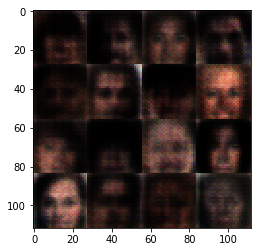

Epoch 1/1... Discriminator Loss: 1.1828... Generator Loss: 0.6021
Epoch 1/1... Discriminator Loss: 1.0825... Generator Loss: 0.7102
Epoch 1/1... Discriminator Loss: 0.9120... Generator Loss: 1.1297
Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 0.5384
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.5502
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 2.1915
Epoch 1/1... Discriminator Loss: 0.6624... Generator Loss: 1.9516
Epoch 1/1... Discriminator Loss: 1.0132... Generator Loss: 1.2636
Epoch 1/1... Discriminator Loss: 1.0725... Generator Loss: 0.7287
Epoch 1/1... Discriminator Loss: 1.0948... Generator Loss: 1.1451


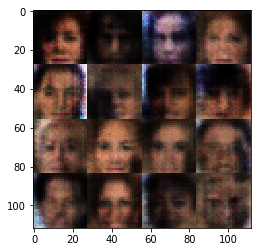

Epoch 1/1... Discriminator Loss: 0.6549... Generator Loss: 1.1539
Epoch 1/1... Discriminator Loss: 1.2182... Generator Loss: 2.4137
Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 2.7402
Epoch 1/1... Discriminator Loss: 0.3441... Generator Loss: 1.7478
Epoch 1/1... Discriminator Loss: 1.0171... Generator Loss: 0.5993
Epoch 1/1... Discriminator Loss: 1.0778... Generator Loss: 0.6354
Epoch 1/1... Discriminator Loss: 0.7598... Generator Loss: 0.9487
Epoch 1/1... Discriminator Loss: 2.8089... Generator Loss: 0.0784
Epoch 1/1... Discriminator Loss: 0.6076... Generator Loss: 1.1199
Epoch 1/1... Discriminator Loss: 2.1561... Generator Loss: 4.4835


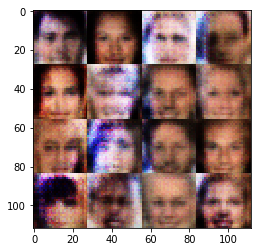

Epoch 1/1... Discriminator Loss: 0.9957... Generator Loss: 1.9438
Epoch 1/1... Discriminator Loss: 0.3731... Generator Loss: 7.6619
Epoch 1/1... Discriminator Loss: 0.6858... Generator Loss: 2.1821
Epoch 1/1... Discriminator Loss: 0.5861... Generator Loss: 1.3381
Epoch 1/1... Discriminator Loss: 0.6774... Generator Loss: 0.9295
Epoch 1/1... Discriminator Loss: 0.5455... Generator Loss: 1.7118
Epoch 1/1... Discriminator Loss: 0.7781... Generator Loss: 1.1577
Epoch 1/1... Discriminator Loss: 0.3051... Generator Loss: 1.9765
Epoch 1/1... Discriminator Loss: 0.3828... Generator Loss: 2.5039
Epoch 1/1... Discriminator Loss: 0.9971... Generator Loss: 0.9857


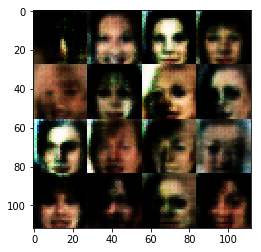

Epoch 1/1... Discriminator Loss: 1.0288... Generator Loss: 0.7231
Epoch 1/1... Discriminator Loss: 0.6987... Generator Loss: 4.4867
Epoch 1/1... Discriminator Loss: 0.5202... Generator Loss: 1.5769
Epoch 1/1... Discriminator Loss: 0.6715... Generator Loss: 1.2249
Epoch 1/1... Discriminator Loss: 0.3363... Generator Loss: 4.6505
Epoch 1/1... Discriminator Loss: 0.9293... Generator Loss: 0.6773
Epoch 1/1... Discriminator Loss: 0.4730... Generator Loss: 1.3217
Epoch 1/1... Discriminator Loss: 0.2336... Generator Loss: 2.0711
Epoch 1/1... Discriminator Loss: 0.3165... Generator Loss: 1.9110
Epoch 1/1... Discriminator Loss: 0.4048... Generator Loss: 1.4093


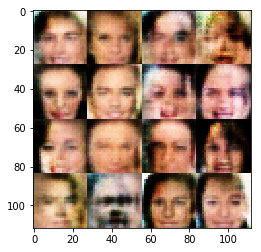

Epoch 1/1... Discriminator Loss: 0.3458... Generator Loss: 2.5511
Epoch 1/1... Discriminator Loss: 0.5901... Generator Loss: 3.7608
Epoch 1/1... Discriminator Loss: 0.3684... Generator Loss: 3.8467
Epoch 1/1... Discriminator Loss: 0.1780... Generator Loss: 2.7040
Epoch 1/1... Discriminator Loss: 0.0883... Generator Loss: 3.8415
Epoch 1/1... Discriminator Loss: 0.7257... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 0.1337... Generator Loss: 2.7373
Epoch 1/1... Discriminator Loss: 0.4335... Generator Loss: 1.4237
Epoch 1/1... Discriminator Loss: 0.6797... Generator Loss: 2.6187
Epoch 1/1... Discriminator Loss: 0.4421... Generator Loss: 1.9853


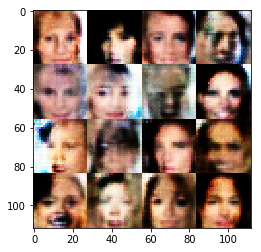

Epoch 1/1... Discriminator Loss: 0.1704... Generator Loss: 2.7513
Epoch 1/1... Discriminator Loss: 0.1911... Generator Loss: 2.3063
Epoch 1/1... Discriminator Loss: 0.1281... Generator Loss: 3.0778
Epoch 1/1... Discriminator Loss: 1.1952... Generator Loss: 0.4698
Epoch 1/1... Discriminator Loss: 1.6606... Generator Loss: 4.1738
Epoch 1/1... Discriminator Loss: 0.7227... Generator Loss: 0.8100
Epoch 1/1... Discriminator Loss: 0.2747... Generator Loss: 1.8028
Epoch 1/1... Discriminator Loss: 0.1250... Generator Loss: 3.0860
Epoch 1/1... Discriminator Loss: 0.1833... Generator Loss: 2.2051
Epoch 1/1... Discriminator Loss: 1.4772... Generator Loss: 3.7203


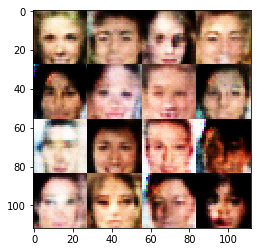

Epoch 1/1... Discriminator Loss: 0.3353... Generator Loss: 2.5216
Epoch 1/1... Discriminator Loss: 0.8618... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 0.1638... Generator Loss: 2.4247
Epoch 1/1... Discriminator Loss: 0.1711... Generator Loss: 5.2168
Epoch 1/1... Discriminator Loss: 0.4465... Generator Loss: 1.9315
Epoch 1/1... Discriminator Loss: 0.4634... Generator Loss: 1.5861
Epoch 1/1... Discriminator Loss: 0.2766... Generator Loss: 2.7095
Epoch 1/1... Discriminator Loss: 0.5151... Generator Loss: 1.1886
Epoch 1/1... Discriminator Loss: 0.8349... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 0.6927... Generator Loss: 3.7902


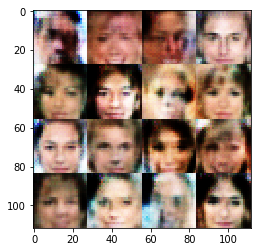

Epoch 1/1... Discriminator Loss: 0.2208... Generator Loss: 2.0178
Epoch 1/1... Discriminator Loss: 0.0700... Generator Loss: 5.1338
Epoch 1/1... Discriminator Loss: 0.5669... Generator Loss: 2.6283
Epoch 1/1... Discriminator Loss: 0.2870... Generator Loss: 3.4263
Epoch 1/1... Discriminator Loss: 0.3172... Generator Loss: 1.7262
Epoch 1/1... Discriminator Loss: 0.6023... Generator Loss: 1.2313
Epoch 1/1... Discriminator Loss: 2.0973... Generator Loss: 0.1576
Epoch 1/1... Discriminator Loss: 0.4069... Generator Loss: 1.4037
Epoch 1/1... Discriminator Loss: 0.2062... Generator Loss: 1.9361
Epoch 1/1... Discriminator Loss: 0.0830... Generator Loss: 4.1927


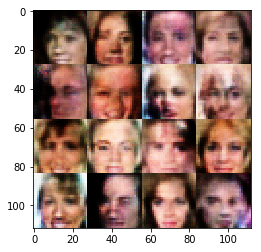

Epoch 1/1... Discriminator Loss: 0.2169... Generator Loss: 4.1763
Epoch 1/1... Discriminator Loss: 0.4247... Generator Loss: 1.3370
Epoch 1/1... Discriminator Loss: 2.1921... Generator Loss: 0.1700
Epoch 1/1... Discriminator Loss: 0.7031... Generator Loss: 1.3153
Epoch 1/1... Discriminator Loss: 1.7521... Generator Loss: 0.2578
Epoch 1/1... Discriminator Loss: 0.2620... Generator Loss: 1.9086
Epoch 1/1... Discriminator Loss: 0.4934... Generator Loss: 1.2595
Epoch 1/1... Discriminator Loss: 0.8962... Generator Loss: 0.6193
Epoch 1/1... Discriminator Loss: 0.0274... Generator Loss: 4.9579
Epoch 1/1... Discriminator Loss: 0.9004... Generator Loss: 0.6166


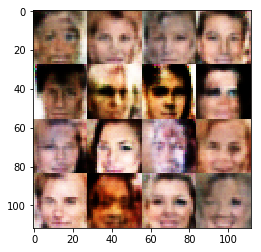

Epoch 1/1... Discriminator Loss: 0.1432... Generator Loss: 5.8542
Epoch 1/1... Discriminator Loss: 0.2137... Generator Loss: 3.5745
Epoch 1/1... Discriminator Loss: 0.1036... Generator Loss: 3.1842
Epoch 1/1... Discriminator Loss: 3.9585... Generator Loss: 0.0293
Epoch 1/1... Discriminator Loss: 0.2738... Generator Loss: 2.3636
Epoch 1/1... Discriminator Loss: 0.3275... Generator Loss: 1.8076
Epoch 1/1... Discriminator Loss: 0.0899... Generator Loss: 3.4196
Epoch 1/1... Discriminator Loss: 0.1721... Generator Loss: 2.4707
Epoch 1/1... Discriminator Loss: 0.8498... Generator Loss: 3.0959
Epoch 1/1... Discriminator Loss: 0.4684... Generator Loss: 1.4532


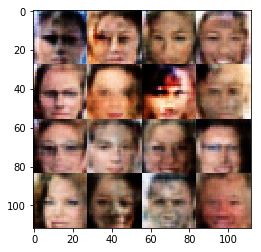

Epoch 1/1... Discriminator Loss: 0.2628... Generator Loss: 2.4076
Epoch 1/1... Discriminator Loss: 0.6584... Generator Loss: 0.9119
Epoch 1/1... Discriminator Loss: 0.4637... Generator Loss: 1.2833
Epoch 1/1... Discriminator Loss: 1.1212... Generator Loss: 0.5775
Epoch 1/1... Discriminator Loss: 0.4643... Generator Loss: 1.5418
Epoch 1/1... Discriminator Loss: 0.2539... Generator Loss: 4.5104
Epoch 1/1... Discriminator Loss: 0.3071... Generator Loss: 3.3399
Epoch 1/1... Discriminator Loss: 0.2493... Generator Loss: 2.0522
Epoch 1/1... Discriminator Loss: 0.6534... Generator Loss: 0.9945
Epoch 1/1... Discriminator Loss: 0.4944... Generator Loss: 1.5519


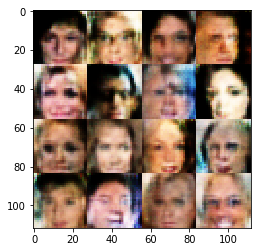

Epoch 1/1... Discriminator Loss: 0.0842... Generator Loss: 4.3301
Epoch 1/1... Discriminator Loss: 0.4157... Generator Loss: 2.9706
Epoch 1/1... Discriminator Loss: 0.2664... Generator Loss: 1.7079
Epoch 1/1... Discriminator Loss: 0.4678... Generator Loss: 1.2502
Epoch 1/1... Discriminator Loss: 0.3152... Generator Loss: 3.4828
Epoch 1/1... Discriminator Loss: 0.1398... Generator Loss: 4.1677
Epoch 1/1... Discriminator Loss: 1.6694... Generator Loss: 0.2587
Epoch 1/1... Discriminator Loss: 0.3505... Generator Loss: 1.7609
Epoch 1/1... Discriminator Loss: 0.3083... Generator Loss: 1.6187
Epoch 1/1... Discriminator Loss: 0.6714... Generator Loss: 1.7655


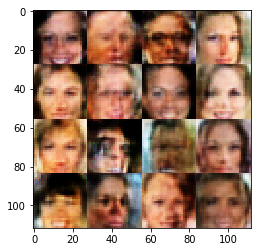

Epoch 1/1... Discriminator Loss: 0.2950... Generator Loss: 1.7513
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.4035
Epoch 1/1... Discriminator Loss: 0.3824... Generator Loss: 2.3718
Epoch 1/1... Discriminator Loss: 0.2527... Generator Loss: 2.4283
Epoch 1/1... Discriminator Loss: 0.3360... Generator Loss: 2.6801
Epoch 1/1... Discriminator Loss: 1.2056... Generator Loss: 4.8961
Epoch 1/1... Discriminator Loss: 0.1377... Generator Loss: 2.6326
Epoch 1/1... Discriminator Loss: 0.5611... Generator Loss: 2.3928
Epoch 1/1... Discriminator Loss: 0.4578... Generator Loss: 1.3917
Epoch 1/1... Discriminator Loss: 0.6586... Generator Loss: 1.0501


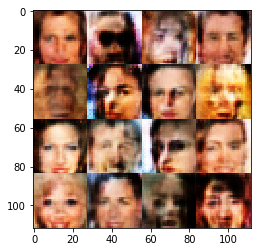

Epoch 1/1... Discriminator Loss: 1.1364... Generator Loss: 0.5047
Epoch 1/1... Discriminator Loss: 0.5324... Generator Loss: 2.9996
Epoch 1/1... Discriminator Loss: 0.2047... Generator Loss: 2.6921
Epoch 1/1... Discriminator Loss: 0.1527... Generator Loss: 2.7398
Epoch 1/1... Discriminator Loss: 0.2122... Generator Loss: 1.9444
Epoch 1/1... Discriminator Loss: 0.3671... Generator Loss: 1.3974
Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 0.5120
Epoch 1/1... Discriminator Loss: 0.3102... Generator Loss: 4.4576
Epoch 1/1... Discriminator Loss: 0.1536... Generator Loss: 3.1052
Epoch 1/1... Discriminator Loss: 1.1738... Generator Loss: 0.5107


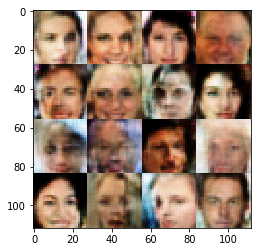

Epoch 1/1... Discriminator Loss: 0.5755... Generator Loss: 1.1093
Epoch 1/1... Discriminator Loss: 0.2541... Generator Loss: 2.2348
Epoch 1/1... Discriminator Loss: 0.3969... Generator Loss: 1.4495
Epoch 1/1... Discriminator Loss: 0.6233... Generator Loss: 0.9660
Epoch 1/1... Discriminator Loss: 0.3580... Generator Loss: 1.6705
Epoch 1/1... Discriminator Loss: 0.0666... Generator Loss: 3.9346
Epoch 1/1... Discriminator Loss: 0.1310... Generator Loss: 5.0557
Epoch 1/1... Discriminator Loss: 0.1611... Generator Loss: 2.9727
Epoch 1/1... Discriminator Loss: 0.0627... Generator Loss: 3.6331
Epoch 1/1... Discriminator Loss: 0.1669... Generator Loss: 3.2919


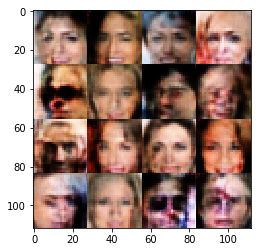

Epoch 1/1... Discriminator Loss: 0.5760... Generator Loss: 1.1659
Epoch 1/1... Discriminator Loss: 0.8722... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 0.2751... Generator Loss: 2.2593
Epoch 1/1... Discriminator Loss: 0.5695... Generator Loss: 1.0357
Epoch 1/1... Discriminator Loss: 0.1331... Generator Loss: 4.4066
Epoch 1/1... Discriminator Loss: 0.1978... Generator Loss: 2.1063
Epoch 1/1... Discriminator Loss: 0.1458... Generator Loss: 3.7509
Epoch 1/1... Discriminator Loss: 0.4476... Generator Loss: 1.3693
Epoch 1/1... Discriminator Loss: 0.1357... Generator Loss: 3.1833
Epoch 1/1... Discriminator Loss: 0.1308... Generator Loss: 4.3046


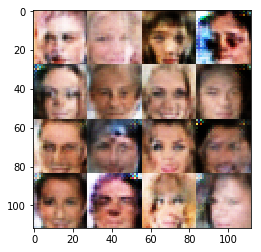

Epoch 1/1... Discriminator Loss: 0.2540... Generator Loss: 1.7581
Epoch 1/1... Discriminator Loss: 0.4895... Generator Loss: 1.2586
Epoch 1/1... Discriminator Loss: 0.6865... Generator Loss: 2.5573
Epoch 1/1... Discriminator Loss: 0.1168... Generator Loss: 4.2979
Epoch 1/1... Discriminator Loss: 0.3398... Generator Loss: 3.1306
Epoch 1/1... Discriminator Loss: 0.3673... Generator Loss: 1.6655
Epoch 1/1... Discriminator Loss: 0.8936... Generator Loss: 0.7691
Epoch 1/1... Discriminator Loss: 0.4371... Generator Loss: 1.5273
Epoch 1/1... Discriminator Loss: 0.2519... Generator Loss: 1.9814
Epoch 1/1... Discriminator Loss: 0.3543... Generator Loss: 2.1941


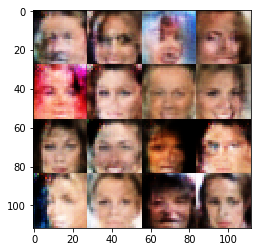

Epoch 1/1... Discriminator Loss: 0.5082... Generator Loss: 2.2728
Epoch 1/1... Discriminator Loss: 0.2190... Generator Loss: 4.0606
Epoch 1/1... Discriminator Loss: 0.7472... Generator Loss: 3.9429
Epoch 1/1... Discriminator Loss: 0.8048... Generator Loss: 0.7068
Epoch 1/1... Discriminator Loss: 0.0718... Generator Loss: 5.1005
Epoch 1/1... Discriminator Loss: 0.2581... Generator Loss: 2.7497
Epoch 1/1... Discriminator Loss: 0.3827... Generator Loss: 2.0807
Epoch 1/1... Discriminator Loss: 1.2882... Generator Loss: 0.4978
Epoch 1/1... Discriminator Loss: 0.8510... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 0.8237... Generator Loss: 0.7625


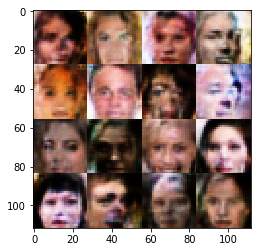

Epoch 1/1... Discriminator Loss: 0.3091... Generator Loss: 2.0752
Epoch 1/1... Discriminator Loss: 0.6088... Generator Loss: 1.4431
Epoch 1/1... Discriminator Loss: 1.6073... Generator Loss: 0.2917
Epoch 1/1... Discriminator Loss: 0.3380... Generator Loss: 2.3675
Epoch 1/1... Discriminator Loss: 0.1390... Generator Loss: 2.7769
Epoch 1/1... Discriminator Loss: 0.1549... Generator Loss: 4.4787
Epoch 1/1... Discriminator Loss: 2.8800... Generator Loss: 0.0887
Epoch 1/1... Discriminator Loss: 0.2299... Generator Loss: 1.9389
Epoch 1/1... Discriminator Loss: 0.1560... Generator Loss: 2.3658
Epoch 1/1... Discriminator Loss: 3.7157... Generator Loss: 7.0984


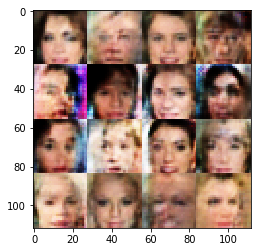

Epoch 1/1... Discriminator Loss: 0.8440... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 0.1975... Generator Loss: 2.6746
Epoch 1/1... Discriminator Loss: 0.1301... Generator Loss: 3.0256
Epoch 1/1... Discriminator Loss: 0.1933... Generator Loss: 4.6844
Epoch 1/1... Discriminator Loss: 0.1932... Generator Loss: 3.2849
Epoch 1/1... Discriminator Loss: 3.5092... Generator Loss: 5.1669
Epoch 1/1... Discriminator Loss: 0.7450... Generator Loss: 1.0317
Epoch 1/1... Discriminator Loss: 0.5079... Generator Loss: 1.5144
Epoch 1/1... Discriminator Loss: 0.1302... Generator Loss: 4.2996
Epoch 1/1... Discriminator Loss: 0.6702... Generator Loss: 0.8892


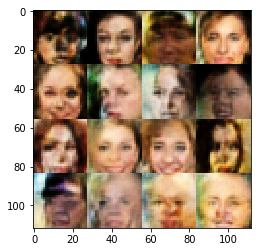

Epoch 1/1... Discriminator Loss: 0.6377... Generator Loss: 0.9596
Epoch 1/1... Discriminator Loss: 0.7554... Generator Loss: 0.8632
Epoch 1/1... Discriminator Loss: 0.5895... Generator Loss: 1.0018
Epoch 1/1... Discriminator Loss: 0.0573... Generator Loss: 3.6243
Epoch 1/1... Discriminator Loss: 0.4717... Generator Loss: 1.1754
Epoch 1/1... Discriminator Loss: 0.0283... Generator Loss: 5.1920
Epoch 1/1... Discriminator Loss: 0.4737... Generator Loss: 1.2188
Epoch 1/1... Discriminator Loss: 0.2526... Generator Loss: 1.7585
Epoch 1/1... Discriminator Loss: 0.9449... Generator Loss: 4.1949
Epoch 1/1... Discriminator Loss: 0.7144... Generator Loss: 0.9799


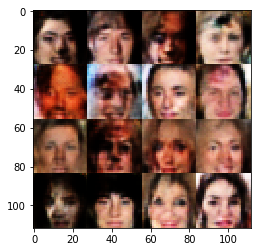

Epoch 1/1... Discriminator Loss: 0.5564... Generator Loss: 1.1187
Epoch 1/1... Discriminator Loss: 0.1515... Generator Loss: 4.0276
Epoch 1/1... Discriminator Loss: 1.1658... Generator Loss: 0.4735
Epoch 1/1... Discriminator Loss: 0.9190... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 0.3461... Generator Loss: 1.6828
Epoch 1/1... Discriminator Loss: 0.5237... Generator Loss: 1.1672
Epoch 1/1... Discriminator Loss: 0.2490... Generator Loss: 2.4641
Epoch 1/1... Discriminator Loss: 0.2244... Generator Loss: 3.9562
Epoch 1/1... Discriminator Loss: 0.6308... Generator Loss: 3.2635
Epoch 1/1... Discriminator Loss: 0.0882... Generator Loss: 3.4638


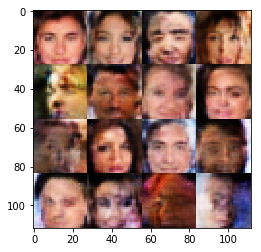

Epoch 1/1... Discriminator Loss: 2.2374... Generator Loss: 0.1941
Epoch 1/1... Discriminator Loss: 1.5951... Generator Loss: 0.2935
Epoch 1/1... Discriminator Loss: 1.0671... Generator Loss: 0.5428
Epoch 1/1... Discriminator Loss: 0.7021... Generator Loss: 0.8495
Epoch 1/1... Discriminator Loss: 0.5153... Generator Loss: 1.2182
Epoch 1/1... Discriminator Loss: 0.6991... Generator Loss: 0.9765
Epoch 1/1... Discriminator Loss: 1.1198... Generator Loss: 0.4752
Epoch 1/1... Discriminator Loss: 0.5818... Generator Loss: 3.0184
Epoch 1/1... Discriminator Loss: 0.4153... Generator Loss: 1.3900
Epoch 1/1... Discriminator Loss: 0.7404... Generator Loss: 0.7960


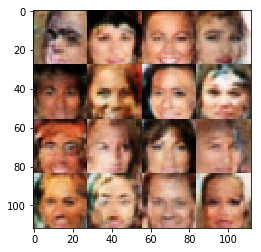

Epoch 1/1... Discriminator Loss: 0.6540... Generator Loss: 0.9695
Epoch 1/1... Discriminator Loss: 0.5317... Generator Loss: 4.0906
Epoch 1/1... Discriminator Loss: 0.3335... Generator Loss: 1.8021
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.3662
Epoch 1/1... Discriminator Loss: 0.6066... Generator Loss: 1.0945
Epoch 1/1... Discriminator Loss: 0.4279... Generator Loss: 1.3545
Epoch 1/1... Discriminator Loss: 0.4335... Generator Loss: 2.0182
Epoch 1/1... Discriminator Loss: 0.4272... Generator Loss: 1.5247
Epoch 1/1... Discriminator Loss: 0.6334... Generator Loss: 1.3576
Epoch 1/1... Discriminator Loss: 0.2982... Generator Loss: 5.3018


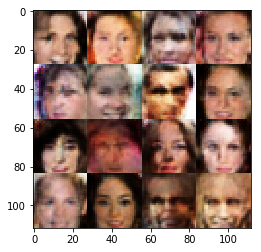

Epoch 1/1... Discriminator Loss: 0.8500... Generator Loss: 2.5370
Epoch 1/1... Discriminator Loss: 0.2872... Generator Loss: 1.8841
Epoch 1/1... Discriminator Loss: 0.4751... Generator Loss: 1.4055
Epoch 1/1... Discriminator Loss: 0.5625... Generator Loss: 1.2133
Epoch 1/1... Discriminator Loss: 0.8171... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 0.4012... Generator Loss: 1.6130
Epoch 1/1... Discriminator Loss: 0.6298... Generator Loss: 1.0130
Epoch 1/1... Discriminator Loss: 0.9385... Generator Loss: 0.6131
Epoch 1/1... Discriminator Loss: 0.3967... Generator Loss: 2.2768
Epoch 1/1... Discriminator Loss: 0.4151... Generator Loss: 2.2250


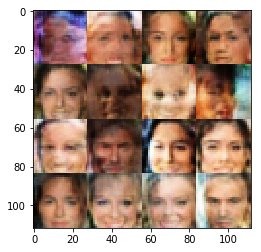

Epoch 1/1... Discriminator Loss: 0.5494... Generator Loss: 1.6893
Epoch 1/1... Discriminator Loss: 0.8919... Generator Loss: 0.7365
Epoch 1/1... Discriminator Loss: 0.0942... Generator Loss: 4.7975
Epoch 1/1... Discriminator Loss: 0.9465... Generator Loss: 0.6918
Epoch 1/1... Discriminator Loss: 0.2490... Generator Loss: 3.5547
Epoch 1/1... Discriminator Loss: 1.2064... Generator Loss: 0.5245
Epoch 1/1... Discriminator Loss: 0.5538... Generator Loss: 2.1605
Epoch 1/1... Discriminator Loss: 0.5927... Generator Loss: 1.4656
Epoch 1/1... Discriminator Loss: 0.2364... Generator Loss: 2.4912
Epoch 1/1... Discriminator Loss: 0.5605... Generator Loss: 2.9182


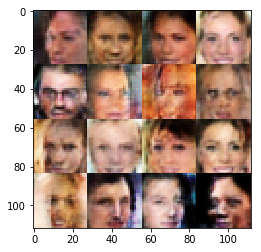

Epoch 1/1... Discriminator Loss: 0.5870... Generator Loss: 1.1347
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 0.4305
Epoch 1/1... Discriminator Loss: 0.5549... Generator Loss: 1.1874
Epoch 1/1... Discriminator Loss: 0.3452... Generator Loss: 5.1793
Epoch 1/1... Discriminator Loss: 0.5017... Generator Loss: 1.4508
Epoch 1/1... Discriminator Loss: 0.7261... Generator Loss: 0.8424
Epoch 1/1... Discriminator Loss: 0.5746... Generator Loss: 1.6027
Epoch 1/1... Discriminator Loss: 0.5201... Generator Loss: 2.1456
Epoch 1/1... Discriminator Loss: 0.4463... Generator Loss: 1.3612
Epoch 1/1... Discriminator Loss: 0.2737... Generator Loss: 1.7819


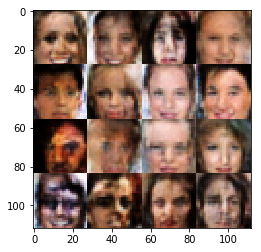

Epoch 1/1... Discriminator Loss: 0.0284... Generator Loss: 5.6682
Epoch 1/1... Discriminator Loss: 0.7103... Generator Loss: 0.8854
Epoch 1/1... Discriminator Loss: 0.4923... Generator Loss: 1.4380
Epoch 1/1... Discriminator Loss: 2.2228... Generator Loss: 5.7262
Epoch 1/1... Discriminator Loss: 0.4674... Generator Loss: 3.3839
Epoch 1/1... Discriminator Loss: 0.4463... Generator Loss: 2.3740


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.